# 0. Pre-Settings and functions
Always execute step 0. - 0.2 

First part is to set Logging and working directory.

In [1]:
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
#from pyforest import *

import random
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np
import os

from ipywidgets import interact
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from src.utils.Utils_io import Console_and_file_logger, ensure_dir
from src.visualization.Visualize import plot_3d_vol, plot_4d_vol, plot_value_histogram
from src.data.Dataset import get_metadata_maybe, filter_4d_vol, copy_meta_and_save, create_3d_volumes_from_4d_files, describe_sitk, describe_volume, describe_path

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

Console_and_file_logger('3d_Data_generation', logging.INFO)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/sarah/git/cmr-LAX-phase-detection


/tmp/ipykernel_9916/1608405404.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2025-06-13 13:06:14.260909: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 13:06:14.282484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-13 13:06:14.622677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-06-13 13:06:14,992 INFO -------------------- Start --------------------
2025-06-13 13:06:14,992 INFO Working directory: /mnt/ssd/sarah/git/cmr-LAX-phase-detection.
2025-06-13 13:06:14,992 INFO Log file: ./logs/3d_Data_generation.log
2025-06-13 13:06:14,992

## 0.1 Select folder with LAX CINE cmr data

In [2]:
from ipyfilechooser import FileChooser
data_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(data_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [176]:
img_path = data_path_chooser.selected
file_regex =   'sax/*.nii.gz' # options: 'lax/*clean.nrrd' || 'lax/*CINE.nii.gz'
path_ = os.path.join(img_path, file_regex)
niftis = sorted(glob.glob(path_))
print(len(niftis))

20


In [177]:
niftis[0]

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_11_40x56x8.nii.gz'

## 0.2 Helper functions

In [73]:
def collect_files(path_chooser, file_regex = "Dataset*"):
    path = path_chooser.selected
    path_ = os.path.join(path, file_regex)
    return sorted(glob.glob(path_))

In [74]:
def visualize_mask(mask):
    mask_img = nib.load(mask)
    mask_data = mask_img.get_fdata()

    # Visualize the mask using matplotlib
    plt.imshow(mask_data[:, :, 0], cmap='gray')  # Assuming a 3D mask, adjust indexing if necessary
    plt.colorbar()
    plt.title('Mask Visualization')
    plt.show()

In [75]:
def stack_niftis(nifti_paths, label=1, crop_x = 30, crop_y = 30):
    nifti_data = []
    pixel_counts = []
    for path in nifti_paths:
        nifti = nib.load(path)
        data = nifti.get_fdata()
        dshape = data.shape
        start_x, end_x, start_y, end_y = crop_x , dshape[0] - crop_x , crop_y, dshape[1] - crop_y
        cropped_data = data[start_x:end_x, start_y:end_y, :]
        
        nifti_data.append(cropped_data)
        
        label_count = np.sum(data == label)  # Count pixels for the specified label
        whole_count = np.sum(data)  
        pixel_counts.append(label_count/whole_count)
        
    stacked_data = np.stack(nifti_data, axis=-1)
    stacked_data = np.transpose(stacked_data, (3, 1, 0, 2))
    return stacked_data, pixel_counts

In [76]:
def open_nifti(file):
    nifti_raw = nib.load(file)
    nifti_data = nifti_raw.get_fdata()
    return nifti_data, nifti_raw

def get_single_slice (file, timestep=0):

    nifti, _ = open_nifti(file)

    # get the shape of NIfTI
    print(nifti.shape)
    
    single_timestep = nifti[:,:,:,timestep]
    
    print(single_timestep.shape)
    
def save_single_timesteps(file, saving_path = None):
    nifti, nifti_raw = open_nifti(file)
    
    if saving_path == None:
        saving_path = file.split('_0000')
        print(saving_path)
    
    extracted_steps = [nifti[:,:,:,i] for i in range(nifti.shape[-1])]
    for i, timestep in enumerate(extracted_steps):
        if i>9:
            file_path = saving_path[0] + '_t' + str(i) + '_0000' + saving_path[1]
        else:
            file_path = saving_path[0] + '_t0' + str(i) + '_0000' + saving_path[1]
        timestep_img = nib.Nifti1Image(timestep, affine=nifti_raw.affine)
        nib.save(timestep_img, file_path)

In [77]:
def open_nifti_sitk(file):
    # Read in file a nifti
    nifti = sitk.ReadImage(file)
    return nifti

def get_single_slice_sitk (file, T=0):
    # Get timestep T of MRI sequence
    nifti = open_nifti_sitk(file)

    # get the shape of NIfTI
    print(f"Size before: {nifti.GetSize()}")
    
    single_timestep = nifti[...,timestep]
    
    print(f"Size after: {single_timestep.GetSize()}")
    return single_timestep
    
def save_single_timesteps_sitk(file, save_dir=None, additional_str='_0000'):
    nifti = open_nifti_sitk(file)
    file_name = os.path.basename(file)
    if save_dir is None:
        save_dir = os.path.dirname(file)
    
    if file.endswith('nii.gz'):
        file_extension = 'nii.gz'
    else:
        file_extension = Path(file).suffix
    
    extracted_steps = [nifti[:,:,:,i] for i in range(nifti.GetSize()[-1])]
    for i, timestep in enumerate(extracted_steps):
        file_path = os.path.join(save_dir, 't' + str(i) + '_' +  file_name.split(file_extension)[0][:-1] + additional_str + '.' + file_extension)
        sitk.WriteImage(timestep, file_path)

# 1. Interactive select subject and segment

In [78]:
import subprocess

def run_segmentation(input_folder="Input", output_folder="Output", dataset="001", configuration="100epochs__3d_fullres", fold="0"):
    nnUNet_command = "nnUNetv2_predict -i " + input_folder + " -o " + output_folder + " -d " + dataset + " -c " + configuration + " -f " + fold

    subprocess.run(nnUNet_command, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [11]:
# Select input path (where to save single timesteps)
from ipyfilechooser import FileChooser
path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [12]:
# Select path with the nnU-Net results 
seg_model_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(seg_model_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [13]:
# Select path with the registration model
reg_model_path_chooser = FileChooser(os.path.join(os.getcwd(), ''), '')
display(reg_model_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [14]:
seg_models = collect_files(seg_model_path_chooser, "Dataset*")
print("Number of nnU-Net datasets: " + str(len(seg_models)))
for dataset in seg_models:
    print(dataset)
    
reg_model_path = reg_model_path_chooser.selected

Number of nnU-Net datasets: 7
/mnt/ssd/sarah/data/nnUNET/nnUNET_results/Dataset001_mnm2
/mnt/ssd/sarah/data/nnUNET/nnUNET_results/Dataset002_mnm2
/mnt/ssd/sarah/data/nnUNET/nnUNET_results/Dataset003_mnm2ZSpacing
/mnt/ssd/sarah/data/nnUNET/nnUNET_results/Dataset004_mnm2_sitk_zaxis
/mnt/ssd/sarah/data/nnUNET/nnUNET_results/Dataset005_mnm2_fimh
/mnt/ssd/sarah/data/nnUNET/nnUNET_results/Dataset006_mnm2_fimh_singleFold
/mnt/ssd/sarah/data/nnUNET/nnUNET_results/Dataset007_mnm2_sax


In [15]:
from src.data.Dataset import load_phase_reg_exp

nda_vects, gt, pred, gt_len, mov, masks, patients = load_phase_reg_exp(reg_model_path_chooser.selected)
print(f"Number of patients found in patients.txt of the model path: {len(patients)}")

['/mnt/ssd/sarah/git/cmr-phase-detection1/exp/media/mnm2/2024-10-17_seg/phase_regression/moved/vects_f0000.npy']
Number of patients found in patients.txt of the model path: 9


In [16]:
from src.visualization.Visualize import show_2D_or_3D
from src.models.predict_phase_reg_model import get_phases_from_vects
@interact_manual
def compare_phases(patient=(0,len(niftis)-1),
                   model=(0, len(seg_models)-1),
                   configuration_2d=False,
                   configuration_3d=True,
                   norm_threshold=(0,100,5),
                   crop_x=(0,100),
                   crop_y=(0,100)
                   ): 
    print("Initial configuration ...")
    file_name = niftis[patient]
    patient_id = file_name.split("/")[-1][0:11]
    
    weight = 1
    
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    cardiac_cycle_length = int(gt_len[patient,:,-1].sum())
    cardiac_cycle_length_ = gt[patient].shape[0]-3 # plot the full length minus border for visualisation
    vects = nda_vects[patient][:cardiac_cycle_length]

    ind = np.argmax(gt[patient][:cardiac_cycle_length],axis=0) # 
    ind_pred = np.argmax(pred[patient][:],axis=0)
    
    input_subfolder_path = os.path.join(path_chooser.selected, "Input_" + patient_id + "_" + str(model))
    if not os.path.exists(input_subfolder_path):
        os.makedirs(input_subfolder_path)
    
    output_subfolder_path = os.path.join(path_chooser.selected, "Output_" + patient_id+ "_" + str(model))
    if not os.path.exists(output_subfolder_path):
        os.makedirs(output_subfolder_path)
        
    dataset = seg_models[model].split("Dataset")[-1][0:3]
    
    if configuration_2d:
        config = "100epochs__2d"
    elif configuration_3d:
        config = "100epochs__3d_fullres"
    
    save_single_timesteps(file_name, [os.path.join(input_subfolder_path, patient_id),".nii.gz"])
    print(f"Processing file: {file_name}")
    print(f"With nnU-Net Segmentation model: {file_name}")

    print("Predict segmentation of patient...")
    run_segmentation(input_subfolder_path, output_subfolder_path, dataset, config)
    
    print("Generate plots of patient...")
    cardiac_cycle_length = int(gt_len[patient,:,-1].sum())
    cardiac_cycle_length_ = gt[patient].shape[0]-3 # plot the full length minus border for visualisation
    figsize = (cardiac_cycle_length, 1)
    
    # CMR plot
    
    temp = mov[patient,:cardiac_cycle_length] # z cardiac_cycle_length_
    fig = show_2D_or_3D(temp, allow_slicing=False)
    ax = fig.get_axes()[0]
    _ = ax.set_ylabel('CMR \n2d+t') #\nmid
    plt.show()
        
    # phase GT plot
    fig= plt.figure(figsize=figsize)
    ax=fig.add_subplot(111)
    ax.set_xticks(ind, minor=False)
    ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    ax.set_yticklabels(phases, rotation=0)
    ind = np.array(ind)
    onehot_gt = np.zeros((ind.size, cardiac_cycle_length)) # cardiac_cycle_length_
    onehot_gt[np.arange(ind.size), ind] = weight
    ax.imshow(onehot_gt,aspect='auto', cmap='bone') # gt as binary phase2time mapping
    _ = ax.set_yticklabels(phases)
    ax.set_title('gt')
    ax.margins(0,0)
    plt.show()
    
    # Stack predicted Niftis
    path_ = os.path.join(output_subfolder_path, patient_id + "_t*.nii.gz")
    masks = sorted(glob.glob(path_))
    
    stacked_masks_data, label_pixel_counts = stack_niftis(masks, label=1, crop_x=crop_x, crop_y=crop_y)
    fig = show_2D_or_3D(stacked_masks_data, allow_slicing=False)
    ax = fig.get_axes()[0]
    _ = ax.set_ylabel('Masks \n2d+t') #\nmid
    plt.show()
    
    plt.figure(figsize=figsize)
    plt.plot(label_pixel_counts)
    plt.xlabel('Time')
    plt.show()
    
    ed_bp = np.argmin(label_pixel_counts)
    es_bp = np.argmax(label_pixel_counts)
    
    pred_bp = np.array([es_bp, 0, ed_bp, 0, 0]) 
    print(pred_bp)
    onehot_pred = np.zeros((pred_bp.size, cardiac_cycle_length)) # cardiac_cycle_length_
    onehot_pred[np.arange(pred_bp.size), pred_bp] = weight
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks(pred_bp, minor=False)
    ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    ax.set_yticklabels(phases, rotation=0)
    _ = plt.imshow(onehot_pred,aspect='auto', cmap='bone')
    _ = ax.set_yticklabels(phases)
    ax.margins(0,0)
    plt.show()
    
#     # dir + norm 2D & 1D plot (4 plots)
#     temp = 0
#     fig, indices = get_phases_from_vects(vects, 
#                                          length=cardiac_cycle_length,
#                                          plot=True,
#                                          # gtind=ind,
#                                          norm_percentile=norm_threshold,
#                                          exp_path=reg_model_path,
#                                          patient=patients[patient])
#     #if save: plt.savefig(os.path.join(vects_chooser.selected, 'patient {}.png'.format(patients[patient])))
#     # phase pred plot
#     indices = np.array(indices)
#     onehot = np.zeros((indices.size, cardiac_cycle_length)) # cardiac_cycle_length_
#     onehot[np.arange(indices.size), indices] = weight
#     fig, ax = plt.subplots(figsize=figsize)
#     ax.set_xticks(indices, minor=False)
#     ax.set_yticks([0, 1, 2, 3, 4], minor=False)
#     ax.set_yticklabels(phases, rotation=0)
#     _ = plt.imshow(onehot,aspect='auto', cmap='bone')
#     _ = ax.set_yticklabels(phases)
#     ax.margins(0,0)
#     plt.show()
#     _ = plt.clf()
#     if 'df_merge' in globals(): print(df_merge['target'].values[patient])
#     print(phases)
#     print('gt_:', ind)
#     print('u_s: ', indices)
#     print('u_bp: ', pred_bp)
    

interactive(children=(IntSlider(value=4, description='patient', max=8), IntSlider(value=3, description='model'…

# 2. Predict Segmentation masks

In [10]:
from ipyfilechooser import FileChooser
save_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(save_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [178]:
save_dir = save_path_chooser.selected
save_dir

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/'

## 2.1 Pre-Process (if necessary)

In [179]:
# Check for dimensionality
test_file = niftis[0]
print(test_file)
img = open_nifti_sitk(test_file)
print(f"Size should be (x,y, depth, time), Size is: {img.GetSize()}")
print(f"Spacing should be greates for depth: {img.GetSpacing()}")

/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_11_40x56x8.nii.gz
Size should be (x,y, depth, time), Size is: (6, 160, 224, 32)
Spacing should be greates for depth: (1.0, 1.0, 1.0, 1.0)


In [180]:
# Re-arrange axes and save files. NOT NECESSARY as the pipeline can also automatically permude the axes if the parameter is given!
def permute_axes_with_temporal_orientation(file, output_path=None, new_order=[ 0, 3, 1, 2], file_type=None):
    img = open_nifti_sitk(file)
    data = sitk.GetArrayFromImage(img) 
    permuted_data = np.transpose(data, new_order)  # (t, x, y, d)

    volumes = [sitk.GetImageFromArray(permuted_data[i]) for i in range(permuted_data.shape[0])]
    new_img = sitk.JoinSeries(volumes)  # create 4D image (x, y, d, t)

    # Fix spacing
    original_spacing = img.GetSpacing()
    if len(original_spacing) == 4:
        new_spacing = (
            original_spacing[2],  # x
            original_spacing[1],  # y
            original_spacing[0],  # d
            original_spacing[3],  # t
        )
        new_img.SetSpacing(new_spacing)

    # Direction: identity for 3D
    new_img.SetDirection(np.eye(4).flatten())  # 4x4 identity

    # Origin
    new_img.SetOrigin(img.GetOrigin())

    # Set output filename
    if output_path is None:
        base, ext = os.path.splitext(file)
        if file_type is None:
            if ext == ".gz":  # For .nii.gz
                base, _ = os.path.splitext(base)
                ext = ".nii.gz"
            elif ext == ".nrrd":
                base, _ = os.path.splitext(base)
                ext = ".nrrd"
            else:
                ext = ".nii"
        else:
            base, _ = os.path.splitext(base)
            ext = file_type
        output_path = base + ext

    sitk.WriteImage(new_img, output_path)
    return output_path


In [181]:
for file in niftis:
    permute_axes_with_temporal_orientation(file)

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_11_40x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_12_56x48x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_13_56x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_14_40x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_16_56x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_19_56x40x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_20_48x40x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_24_56x48x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_26_72x64x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_2_64x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_31_48x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_35_56x48x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_36_56x48x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_38_56x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_46_64x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_48_56x48x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_49_40x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_5_40x64x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_6_56x56x8.nii.gz'

'/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_9_56x56x8.nii.gz'

In [182]:
# Change depth spacing

def adjust_z_spacing(nifti_paths , z_spacing = 10):
    path = os.path.dirname(nifti_paths[0])
    print(path)
    
    for file in nifti_paths:
        new_img = sitk.ReadImage(file)
        orig_spacing = new_img.GetSpacing()
        
        if len(orig_spacing) == 4:
            new_spacing = [orig_spacing[0], orig_spacing[1], z_spacing, orig_spacing[3]]
        elif len(orig_spacing) == 3:
            new_spacing = [orig_spacing[0], orig_spacing[1], z_spacing]
            
        new_img.SetSpacing(new_spacing)

        file_name = file
        sitk.WriteImage(new_img, file_name)
        
def adjust_x_spacing(nifti_paths , x_spacing = 10):
    path = os.path.dirname(nifti_paths[0])
    print(path)
    
    for file in nifti_paths:
        new_img = sitk.ReadImage(file)
        orig_spacing = new_img.GetSpacing()
        
        if len(orig_spacing) == 4:
            new_spacing = [x_spacing,  orig_spacing[1], orig_spacing[2], orig_spacing[3]]
        elif len(orig_spacing) == 3:
            new_spacing = [x_spacing, orig_spacing[1], orig_spacing[2]]
            
        new_img.SetSpacing(new_spacing)

        file_name = file
        sitk.WriteImage(new_img, file_name)
        
adjust_z_spacing(niftis)


/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax


## 2.2 Predict segmentation

In [183]:
len(niftis)

20

In [184]:
from src.models.predict_seg_with_nn_unet import predict_segmentation

#change permute if axes are not in the correct order
predict_segmentation(niftis, save_dir, dataset="008", configuration="3d_fullres", fold="0", clean_memory=True, permute=[1,2,0])

/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_11_40x56x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_12_56x48x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_13_56x56x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_14_40x56x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_16_56x56x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_19_56x40x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_20_48x40x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_24_56x48x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_26_72x64x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_2_64x56x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample_31_48x56x8.nii.gz
/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/sax/sample

# 3 Key-frame detection with VL BP volume

In [126]:
from src.utils.Metrics import cfd  # Assuming cfd is a function you have defined in your project

def get_bp_volume_curve(file, label=1, crop_x=0, crop_y=0):
    nifti = sitk.ReadImage(file)
    cmr_sequence = sitk.GetArrayFromImage(nifti)
    pixel_counts = []
    nifti_data = []
    if type(label) == int:
        label = [label]
    label_count = 0
    for i in range(nifti.GetSize()[-1]):
        timestep = nifti[:, :, :, i]
        data = sitk.GetArrayFromImage(timestep)
        dshape = data.shape
        start_x, end_x, start_y, end_y = crop_x , dshape[0] - (crop_x+20) , crop_y, dshape[1] - crop_y
        cropped_data = data[:, start_x:end_x, start_y+20:end_y]
        for l in label:
            count = np.sum(data == label)  # Count pixels for the specified label
            label_count = label_count + count
        
        pixel_counts.append(label_count)
        nifti_data.append(cropped_data)
        label_count = 0

    stacked_data = np.stack(nifti_data, axis=-1)
    stacked_data = np.transpose(stacked_data, (3, 1, 2, 0))
    return stacked_data, pixel_counts

In [127]:
from ipyfilechooser import FileChooser
masks_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(masks_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [185]:
masks_path = masks_path_chooser.selected
file_regex =  'masks/*masks.nrrd'  # options:  'lax/*masks.(nii.gz|nrrd)' || 'lax/*CINE_masks.nii.gz'
path_ = os.path.join(masks_path, file_regex)
masked_niftis = sorted(glob.glob(path_))
path_gt = os.path.join(masks_path, "phases.csv")
print(path_gt)
print(len(masked_niftis))

try:
    gt_df = pd.read_csv(sorted(glob.glob(path_gt))[0])
    print(gt_df)
except Exception as e:
    print("No gt dataframe available...")
    gt_df = None

/mnt/ssd/sarah/data/synthetic_Marvin/4D_samples/570_100/phases.csv
20
No gt dataframe available...


## 3.1 LV BP "Volume" (Area) Curves

In [194]:
from scipy.interpolate import interp1d

def one_hot_encode(indices, seq_len):
    one_hot_matrix = np.zeros((len(indices), seq_len), dtype=int)
    for i, idx in enumerate(indices):
        if idx < seq_len:
            one_hot_matrix[i, idx] = 1
    return one_hot_matrix


def interpolate_curve(curve, target_length):
    x_original = np.linspace(0, 1, len(curve))
    x_interpolated = np.linspace(0, 1, target_length)
    interpolator = interp1d(x_original, curve, kind='linear')
    return interpolator(x_interpolated)

def normalize_curve(curve):
    min_val = np.min(curve)
    max_val = np.max(curve)
    return (curve)/(max_val - min_val)


In [195]:
def align_vol_curve(curve, gt, pred, seq_len=40, interpolate=False):
    curve = np.array(curve)
    curve = normalize_curve(curve)
    
    gt_ed = gt[0]
    ed_pred_rolled = np.roll(pred[0], -1*gt_ed)
    es_pred_rolled = np.roll(pred[1], -1*gt_ed)
    pred_rerolled = ed_pred_rolled, es_pred_rolled
    
    curve_ali = np.roll(curve, -1*gt_ed)
    
    if interpolate:
        print('interpolate curve')
        curve_ali = interpolate_curve(curve_ali, seq_len)
    
    return curve_ali, pred_rerolled

In [196]:
len(masked_niftis)

20

In [197]:
results = []
imgs = []
volume_curves = []
gt_inds = []
pred_inds = []
cardiac_cycle_len_list = []

seq_len = 34

# Handle missing ground truth
if gt_df is None:
    gt_entries = [None] * len(masked_niftis)
else:
    gt_entries = list(gt_df.itertuples(index=False))


# Iterate through each image path and corresponding ground truth data
for img_path, gt in zip(masked_niftis, gt_entries):
    img, pixel_counts = get_bp_volume_curve(img_path)
    
    _, pixel_counts_myo = get_bp_volume_curve(img_path, label=2)
    cardiac_cycle_len = img.shape[0]
    name = img_path.split('/')[-1]
    es_bp = np.argmin(pixel_counts)
    ed_bp = np.argmax(pixel_counts)
    
    # Ground truth values from the DataFrame
    if gt is None:
        ed_gt = 0
        es_gt = cardiac_cycle_len // 3
    else:
        ed_gt = gt[0]
        es_gt = gt[1]
    
    # Calculate corrected frame difference (CFD)
    ed_cfd = cfd(ed_bp, ed_gt, cardiac_cycle_len)
    es_cfd = cfd(es_bp, es_gt, cardiac_cycle_len)
    
    aligned_curve, pred_aligned = align_vol_curve(pixel_counts, [ed_gt, es_gt], [ed_bp, es_bp], seq_len=seq_len)
    
    aligned_curve_myo, _ = align_vol_curve(pixel_counts_myo, [ed_gt, es_gt], [ed_bp, es_bp], seq_len=seq_len)
    # Append results to the list
    results.append({
        'patient': name,
        'ED#': ed_bp,
        'ED_gt': ed_gt,
        'ED': ed_cfd,
        'ES#': es_bp,
        'ES_gt': es_gt,
        'ES': es_cfd,
        'volume':pixel_counts,
        'volume_aligned': aligned_curve,
        'pred_aligned': pred_aligned,
        'myo': pixel_counts_myo,
        'myo_aligned': aligned_curve_myo
    })
    
    # Append volume curve list
    volume_curves.append(pixel_counts)
    
    # Append gt and pred list 
    gt_inds.append([ed_gt, es_gt])
    pred_inds.append([ed_bp, es_bp])
    
    # Append cardiac cycle length list
    cardiac_cycle_len_list.append(len(pixel_counts))
    
    
    imgs.append(img)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)
# Display the DataFrame
print(results_df)
patient = results_df.iloc[0]
print(patient)
results_df.to_csv(os.path.join(masks_path,"base_cfd.csv"))

                         patient  ED#  ED_gt  ED  ES#  ES_gt  ES  \
0   sample_11_40x56x8_masks.nrrd    0      0   0    8     10   2   
1   sample_12_56x48x8_masks.nrrd   29      0   3   14     10   4   
2   sample_13_56x56x8_masks.nrrd   22      0  10   31     10  11   
3   sample_14_40x56x8_masks.nrrd   24      0   8   10     10   0   
4   sample_16_56x56x8_masks.nrrd   29      0   3    9     10   1   
5   sample_19_56x40x8_masks.nrrd   28      0   4   11     10   1   
6   sample_20_48x40x8_masks.nrrd   22      0  10    6     10   4   
7   sample_24_56x48x8_masks.nrrd   29      0   3    9     10   1   
8   sample_26_72x64x8_masks.nrrd    0      0   0   11     10   1   
9    sample_2_64x56x8_masks.nrrd   26      0   6   10     10   0   
10  sample_31_48x56x8_masks.nrrd   27      0   5   12     10   2   
11  sample_35_56x48x8_masks.nrrd   24      0   8   10     10   0   
12  sample_36_56x48x8_masks.nrrd    1      0   1   16     10   6   
13  sample_38_56x56x8_masks.nrrd    0      0   0

sample_11_40x56x8_masks.nrrd


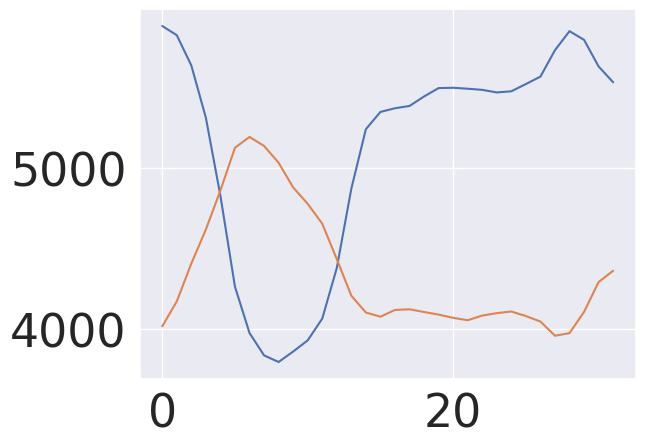

sample_12_56x48x8_masks.nrrd


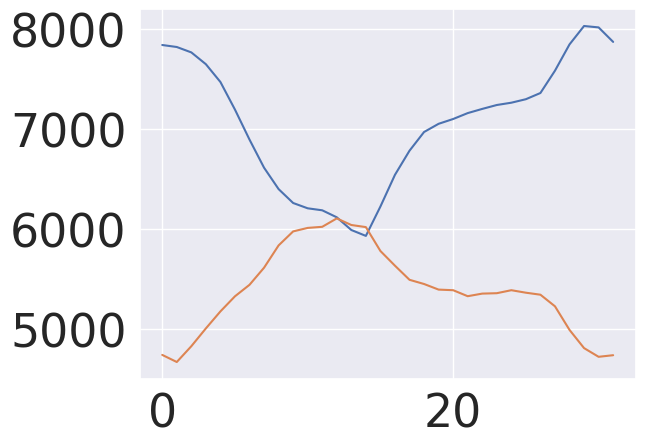

sample_13_56x56x8_masks.nrrd


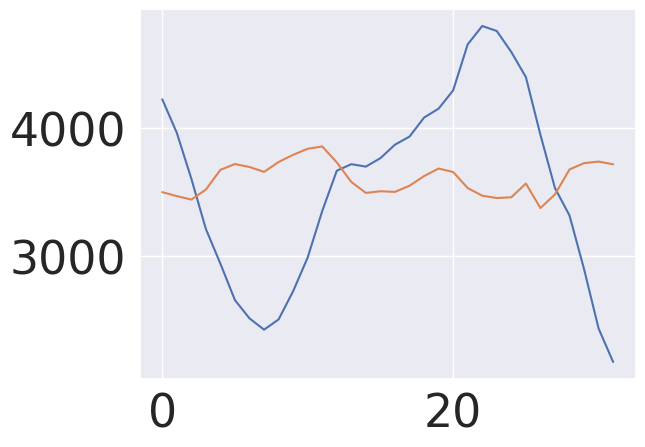

sample_14_40x56x8_masks.nrrd


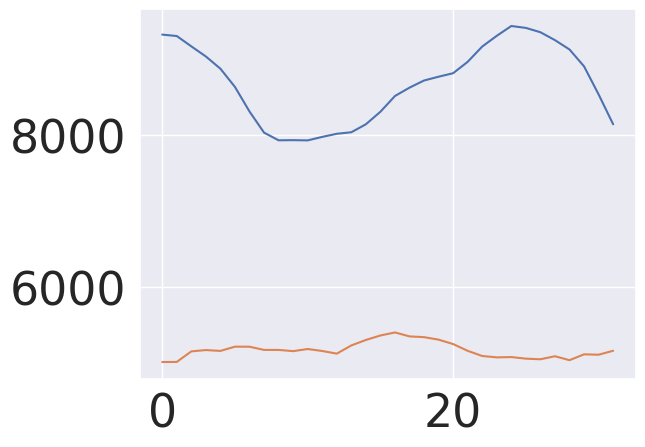

sample_16_56x56x8_masks.nrrd


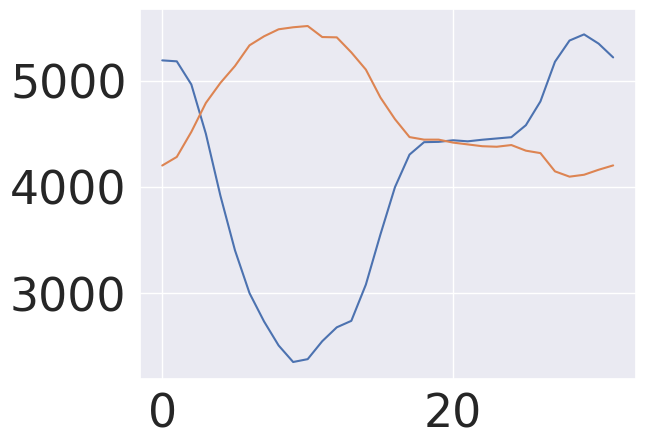

sample_19_56x40x8_masks.nrrd


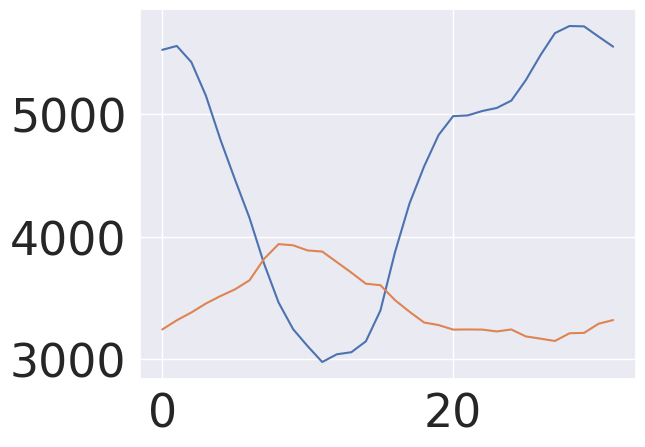

sample_20_48x40x8_masks.nrrd


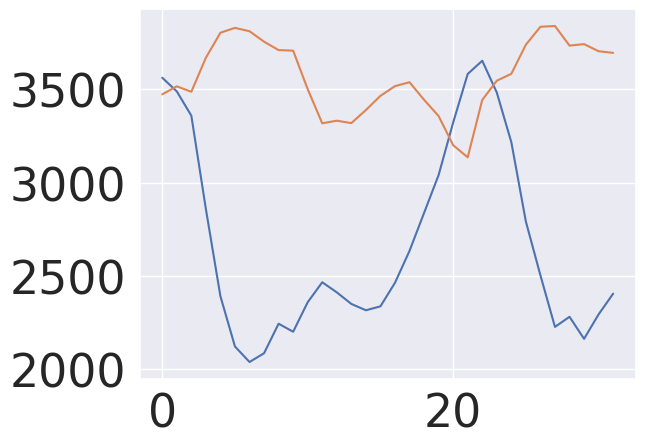

sample_24_56x48x8_masks.nrrd


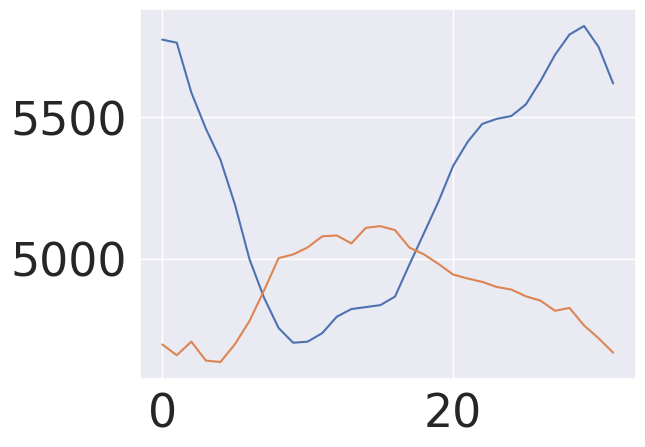

sample_26_72x64x8_masks.nrrd


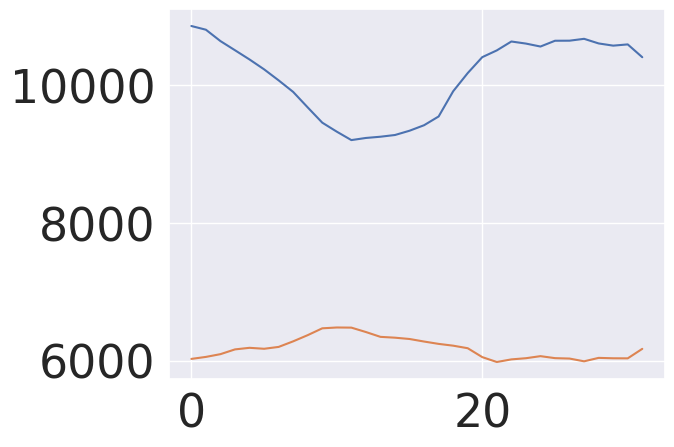

sample_2_64x56x8_masks.nrrd


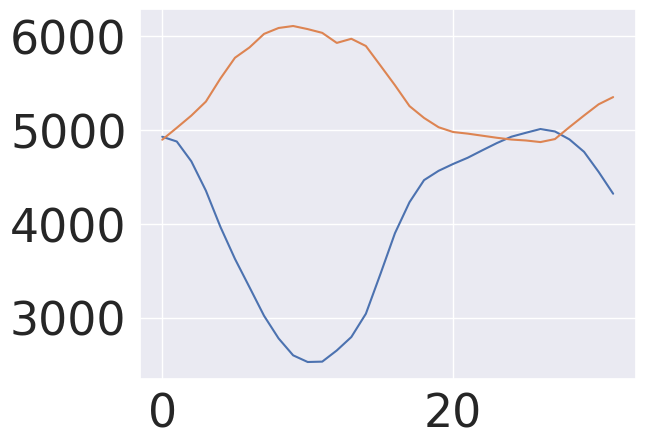

sample_31_48x56x8_masks.nrrd


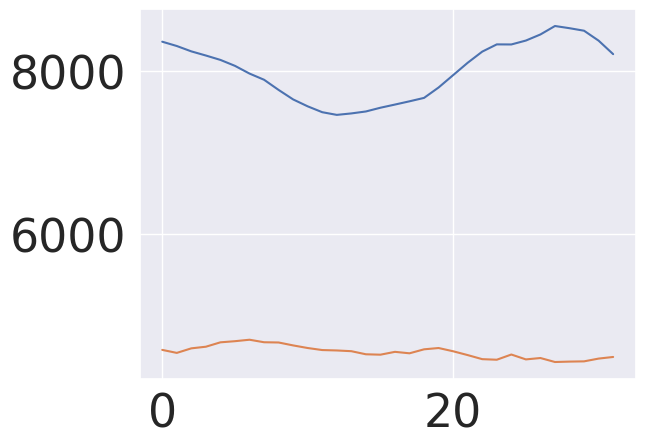

sample_35_56x48x8_masks.nrrd


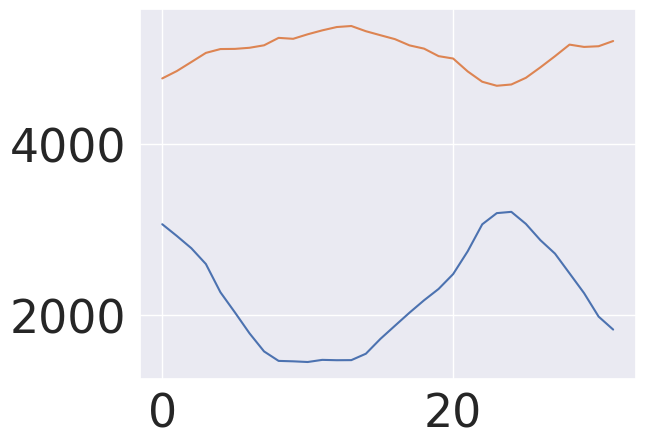

sample_36_56x48x8_masks.nrrd


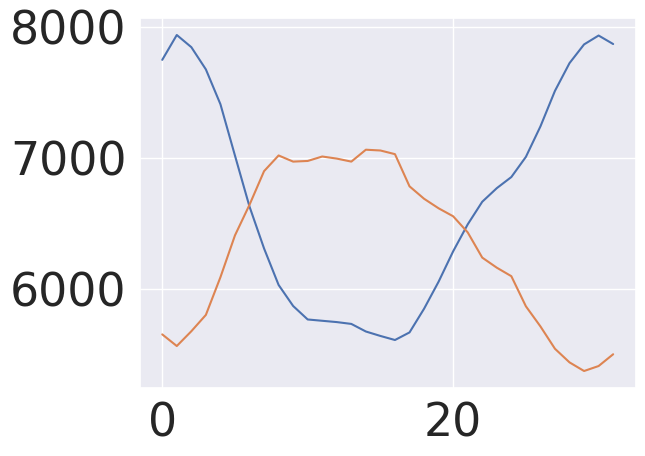

sample_38_56x56x8_masks.nrrd


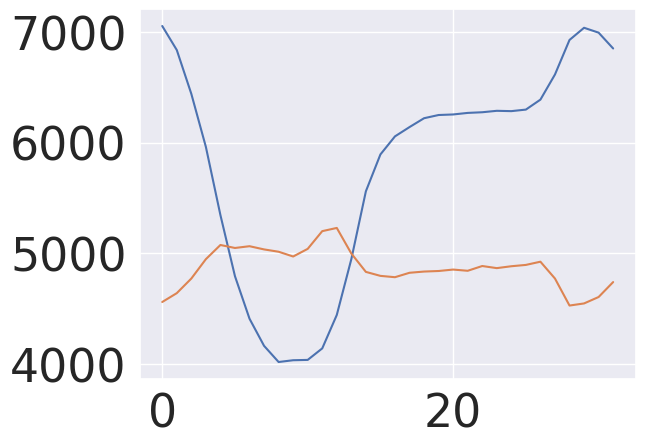

sample_46_64x56x8_masks.nrrd


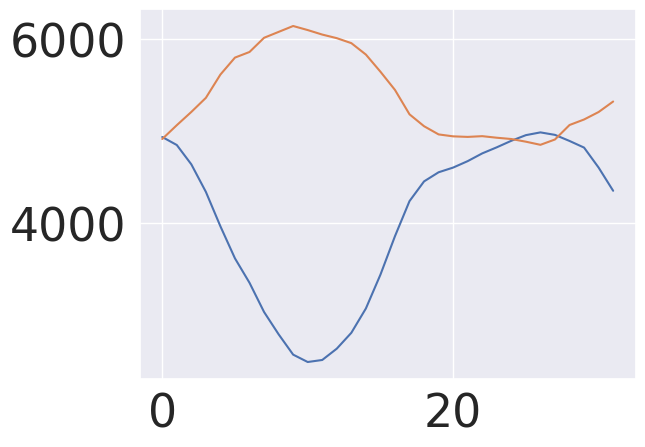

sample_48_56x48x8_masks.nrrd


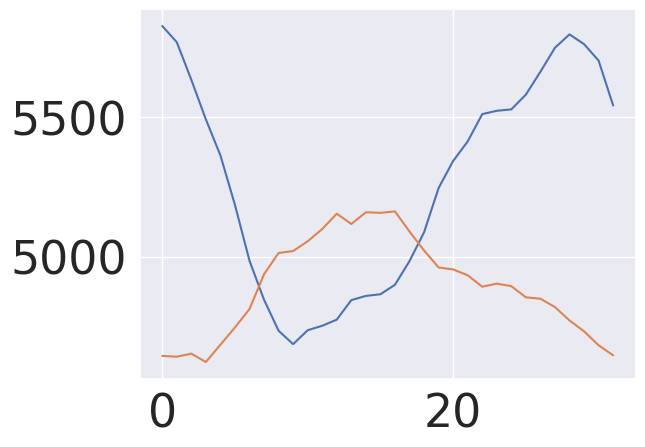

sample_49_40x56x8_masks.nrrd


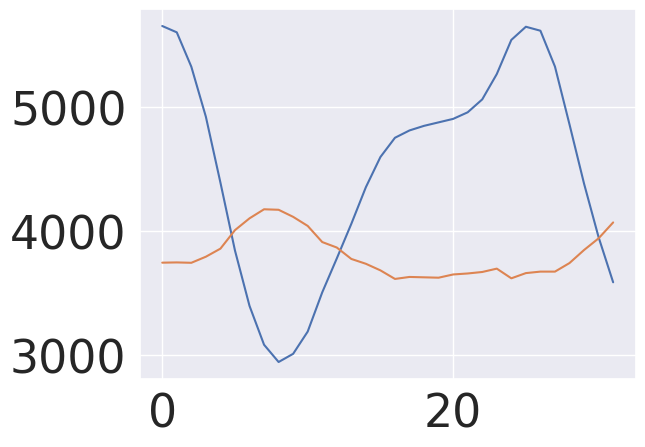

sample_5_40x64x8_masks.nrrd


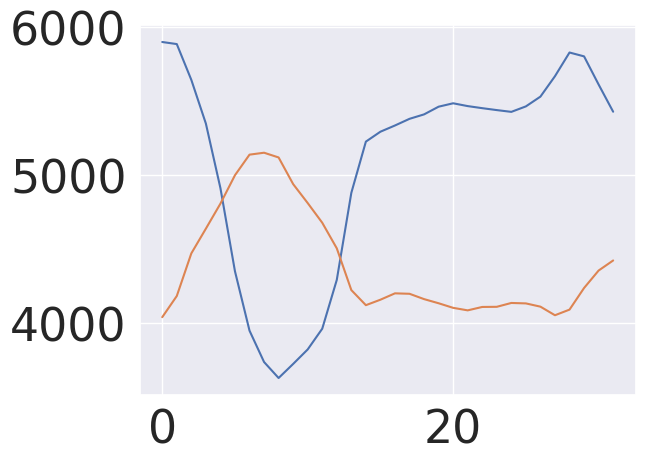

sample_6_56x56x8_masks.nrrd


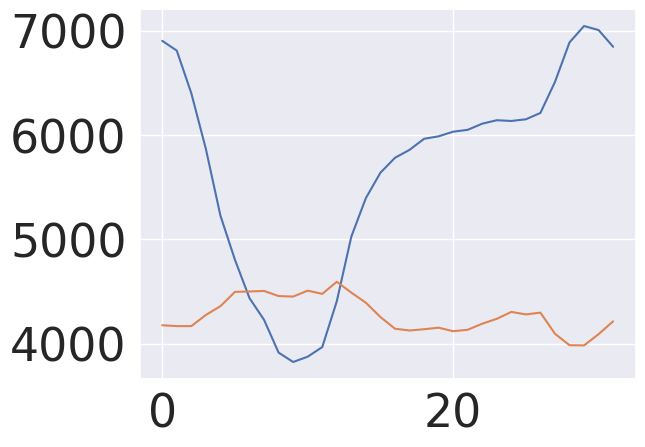

sample_9_56x56x8_masks.nrrd


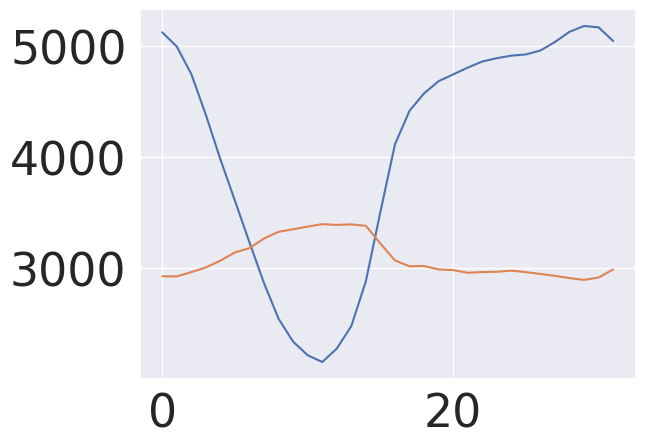

In [198]:
for patient in results_df.values:
    print(patient[0])
    plt.plot(patient[7])
    # plt.plot(patient[8])
    # plt.plot(patient[9])
    plt.plot(patient[10])
    plt.show()

mean overall
 mean     2.88
SD       3.00
median   2.00
dtype: float64
    mean   SD  median
ED  3.65 3.41    3.00
ES  2.10 2.59    1.00


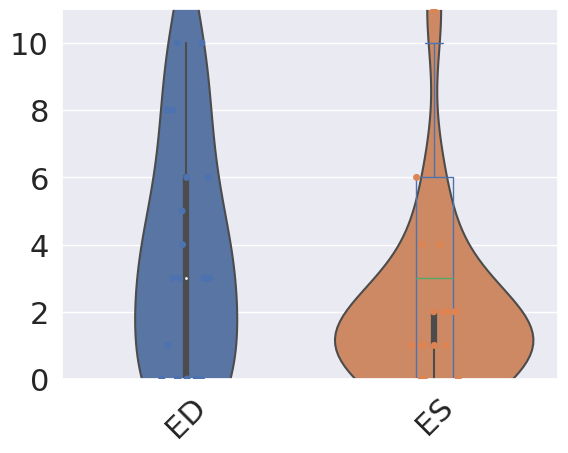

In [199]:
from src.visualization.Visualize import plot_pfd_per_phase_as_violin

plot_pfd_per_phase_as_violin(results_df[['ED', 'ES']])

In [200]:
pred_inds_onehot = [one_hot_encode(pred, seq_len) for pred in pred_inds]


adjusted_curves = []
pred_rerolled = []

for curve, gt, pred in zip(volume_curves,  pred_inds_onehot, gt_inds):
    curve = np.array(curve)
    curve = normalize_curve(curve)
    
    gt_ed = gt[0]
    ed_pred_rolled = np.roll(pred[0], -1*gt_ed)
    es_pred_rolled = np.roll(pred[1], -1*gt_ed)
    
    pred_rerolled.append([np.where(ed_pred_rolled == 1)[0], np.where(es_pred_rolled ==1)[0]])
    
    curve_rolled = np.roll(curve, -1*gt_ed)
    
    
    adjusted_curve = interpolate_curve(curve_rolled, seq_len)
    adjusted_curves.append(adjusted_curve)
    
    vols_alignedscaled = np.stack(adjusted_curves)
    



2025-06-16 18:29:25,270 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


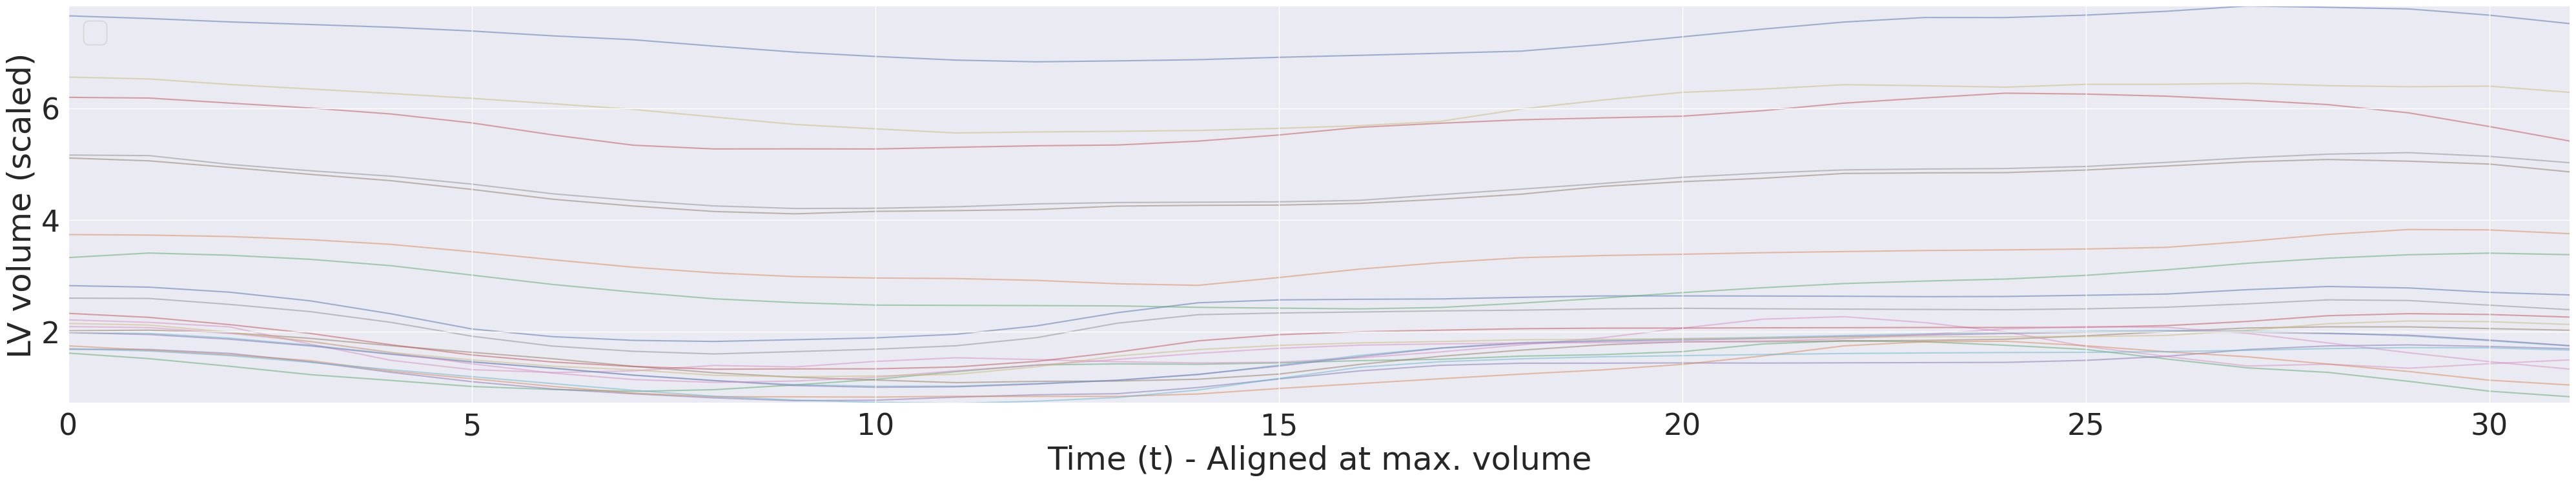

In [201]:
import seaborn as sb
import pandas as pd

ax1_label = 'LV volume (scaled)'

def moving_average(data, window_size=2):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

sb.set_context('paper')
sb.set(font_scale=3)
fig, ax = plt.subplots(figsize=(50, 8))
ax.margins(0, 0)
# for n in vols_alignedscaled:
for n in results_df["volume_aligned"]:
    # _ = ax.plot(moving_average(n), alpha=0.5, zorder=0)
    _ = ax.plot(n, alpha=0.5, zorder=0)

df = pd.DataFrame(vols_alignedscaled).melt()
# _ = sb.lineplot(x='variable', y='value', data=df, color='blue', label=r'LV volume', ci='sd', err_style='bars',
#                 zorder=2, legend=False, ax=ax)
# _ = ax.set_title('Mean direction +/- SD - aligned at ED')
pred_inds = np.array(pred_rerolled)
# _ = ax.set_xticks(np.rint(pred_inds.mean(axis=0)), minor=False)
_ = ax.set_xlabel('Time (t) - Aligned at max. volume')
_ = ax.set_ylabel(ax1_label)
_ = ax.legend(loc='upper left')

plt.show()

### 3.1.2 Curves per pathology 

/tmp/ipykernel_1852293/1595060826.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')
2025-03-14 13:23:06,351 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------
Bold: 284
------------------------------------


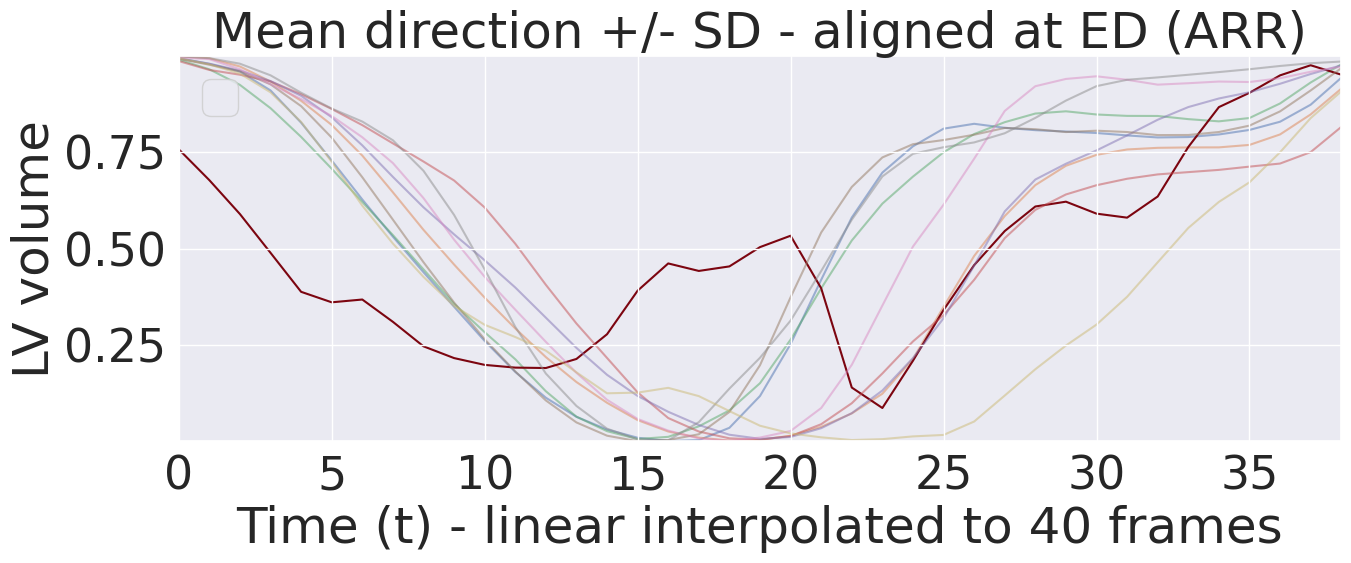

2025-03-14 13:23:06,442 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


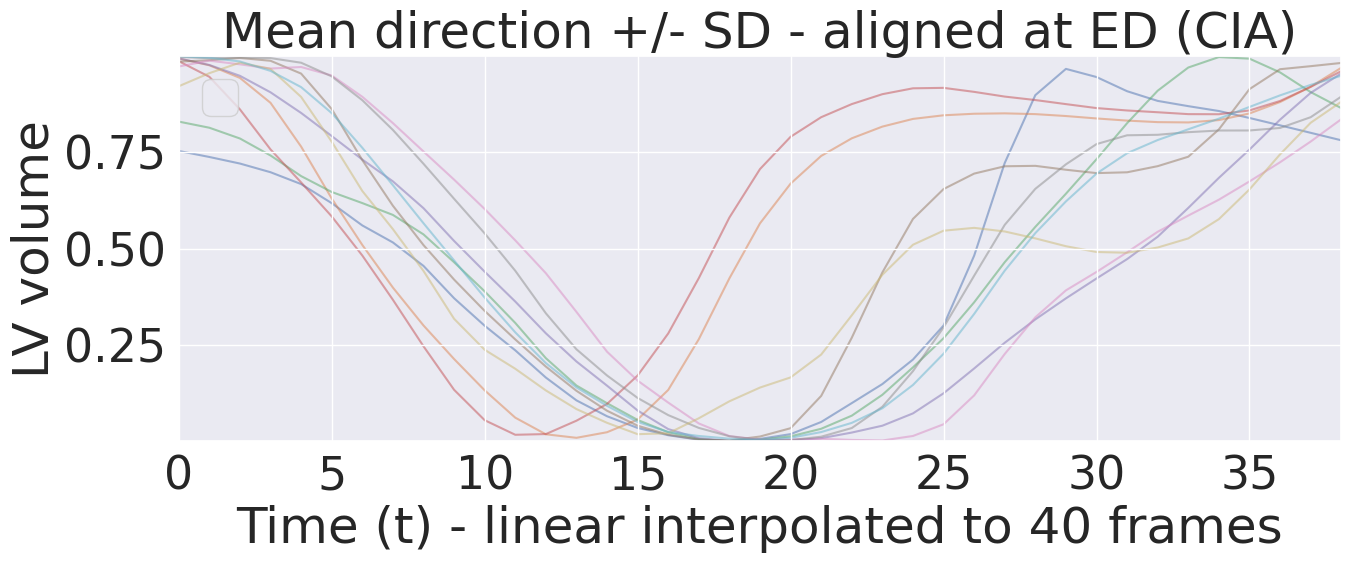

2025-03-14 13:23:06,533 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


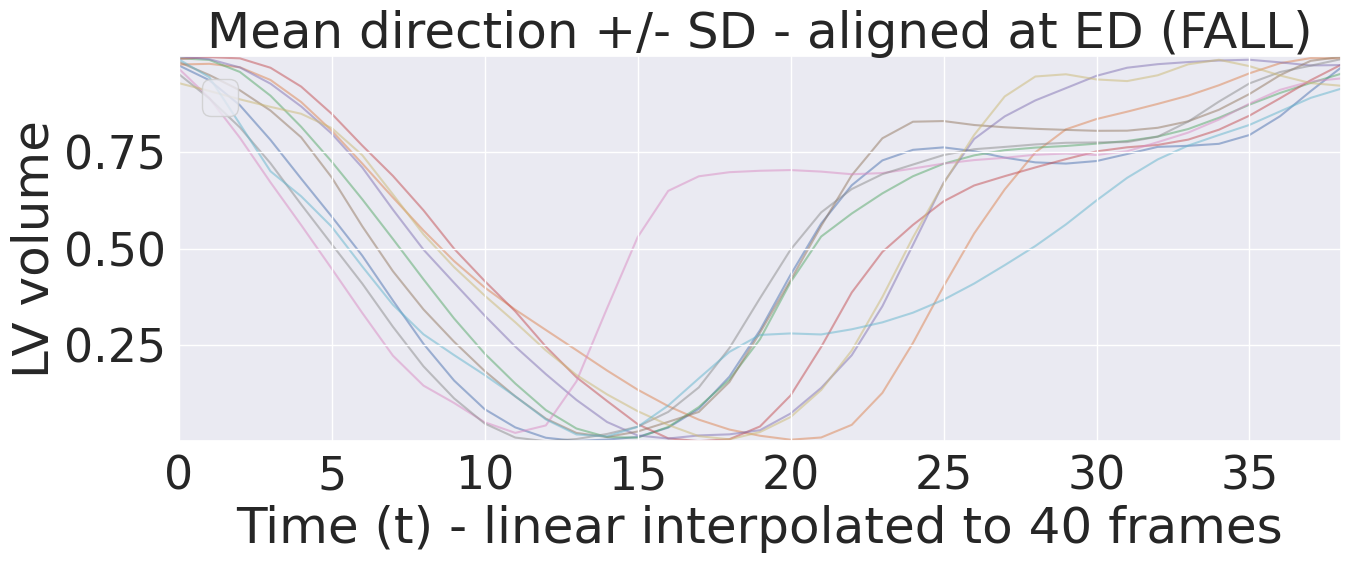

2025-03-14 13:23:06,624 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


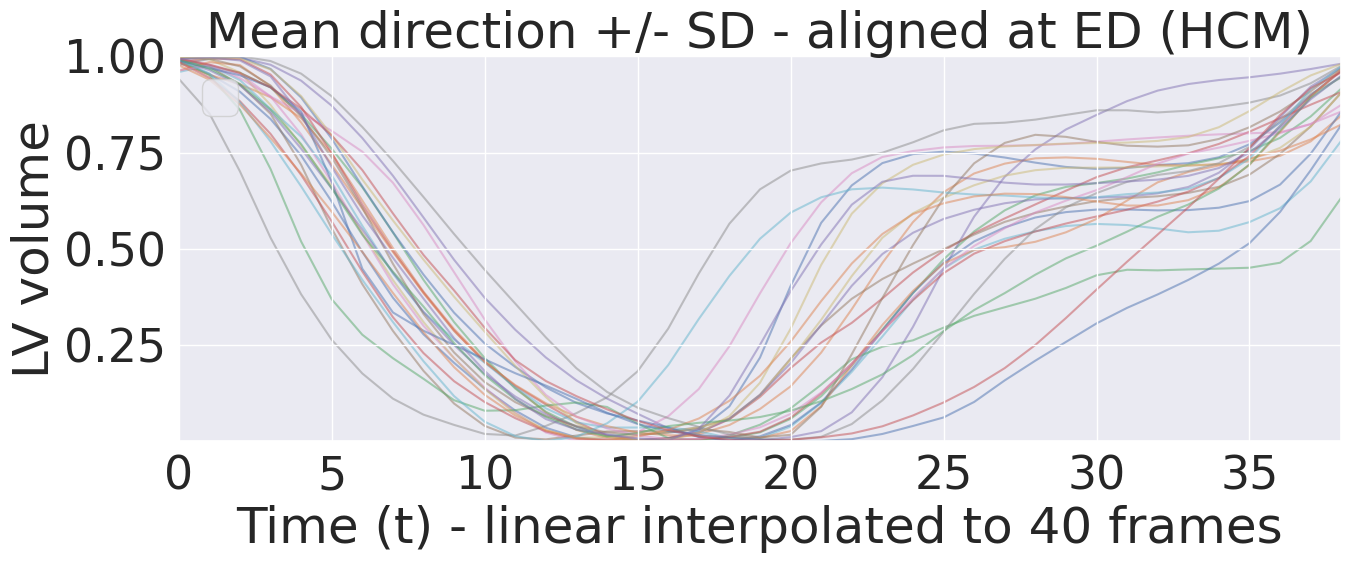

2025-03-14 13:23:06,725 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------
Bold: 244
------------------------------------


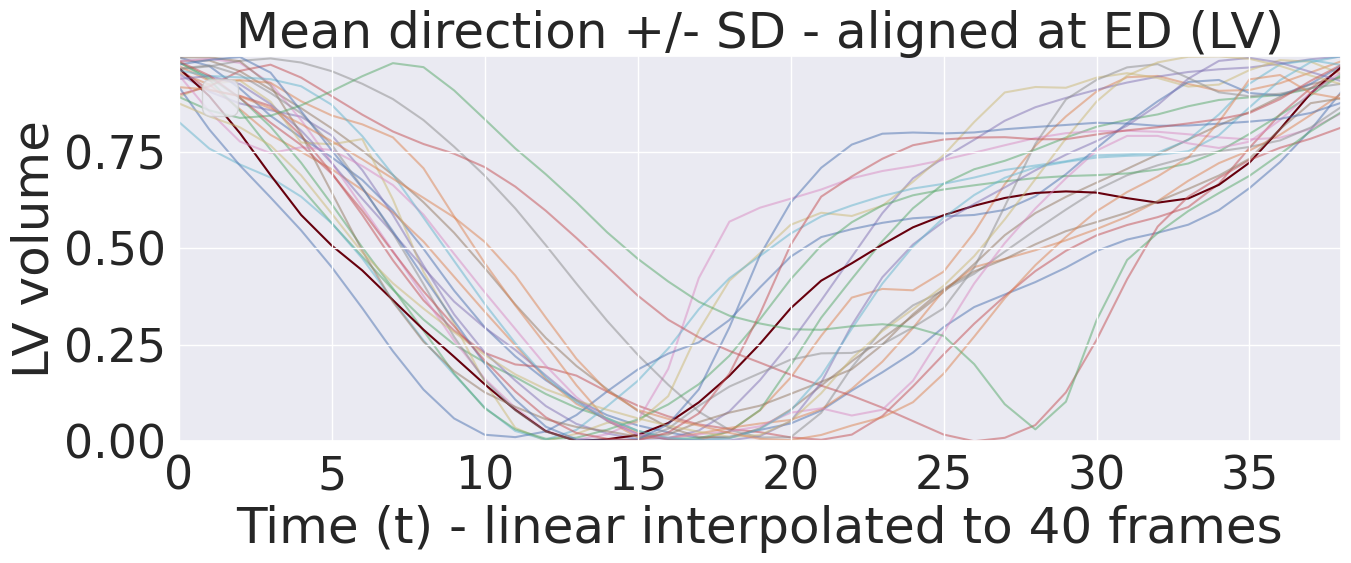

2025-03-14 13:23:06,826 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


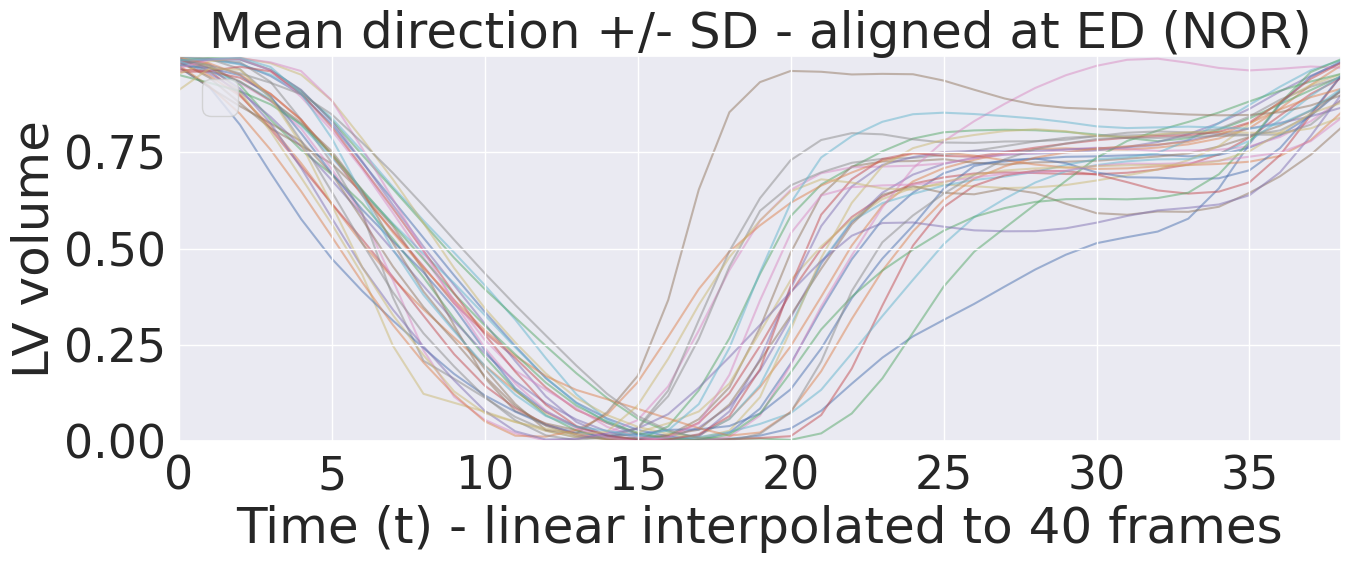

2025-03-14 13:23:07,326 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------
Bold: 335
------------------------------------


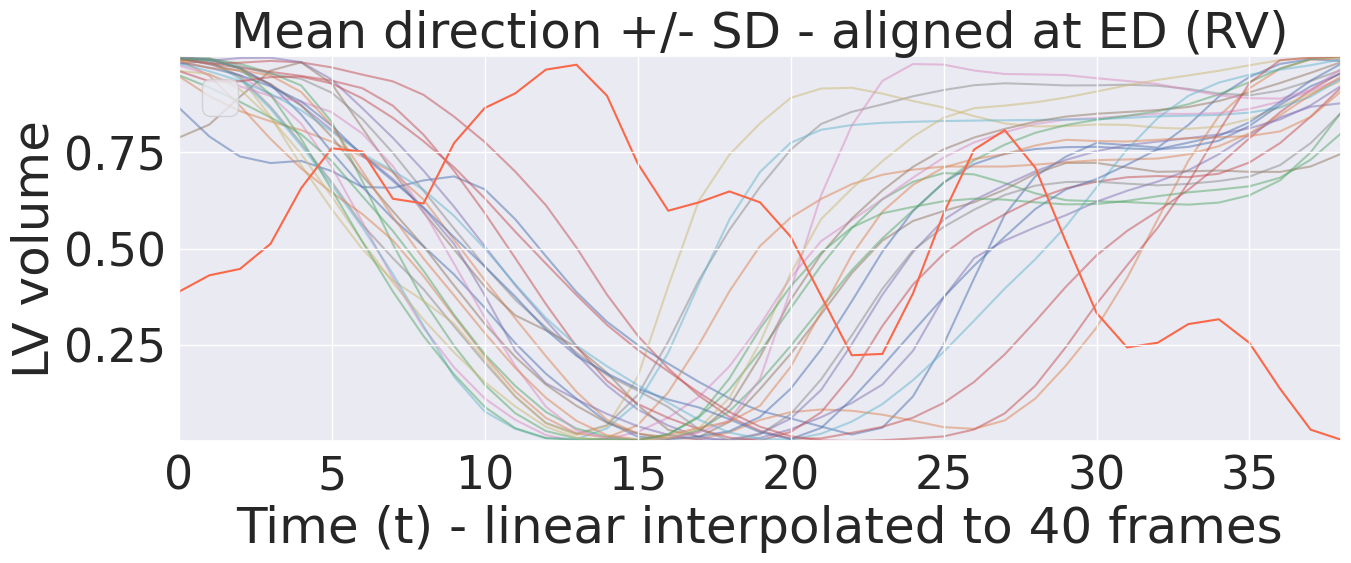

2025-03-14 13:23:07,431 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------
Bold: 355
------------------------------------


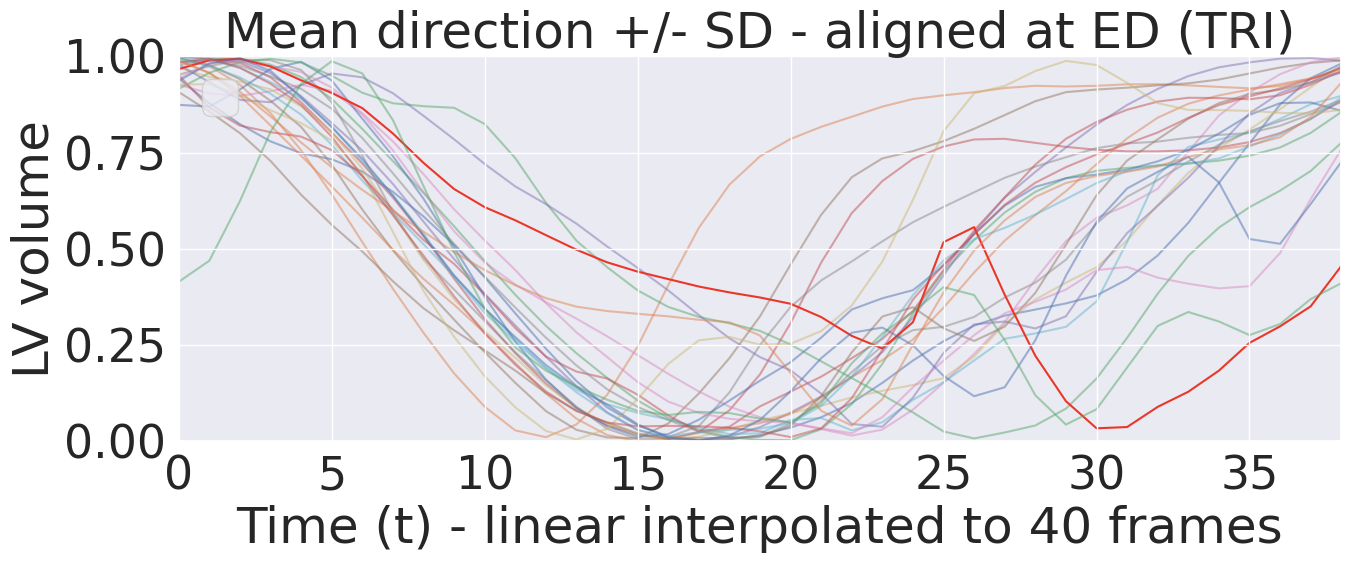

In [317]:
import matplotlib.cm as cm
# Plot per patholgy
def extract_patient_id(filename):
    return filename.split('_')[0]

def scale_vol_curve(curve, seq_len=40):
    curve = np.array(curve)
    curve = normalize_curve(curve)
    curve_ali = interpolate_curve(curve, seq_len)
    
    return curve_ali

def plot_volumes_per_pathology(info_df, results_df, pid="SUBJECT_CODE", group_by="DISEASE"):
    cmap = cm.get_cmap('Reds')
    exclude_pid = [ 244, 284, 335, 355]
    # [209, 244, 284, 303, 311, 349, 354, 359 ] [208, 209, 239, 241, 242, 244, 284, 303, 311, 318, 335, 349, 354, 359] # [239, 244, 284, 335]
    info_df[pid] = info_df[pid].astype(str)
    results_df[pid] = results_df['patient'].apply(extract_patient_id).astype(str)
    merged_df = pd.merge(info_df, results_df,on=pid, how='inner')
    # Group the data by pathology
    for pathology, group in merged_df.groupby(group_by):
        
        if group.empty:
            continue
        volume_curves = group['volume_aligned'].tolist()
        # volume_curves = group['volume'].tolist()
        
        myo_curves = group['myo_aligned'].tolist()
        patient_IDs = group["SUBJECT_CODE"].tolist()
        
        # Plot the curves for this pathology
        sb.set_context('paper')
        sb.set(font_scale=3)
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.margins(0, 0)

        for curve, myo_curve, patient_id in zip(volume_curves, myo_curves, patient_IDs):
            # curve = scale_vol_curve(curve)
            if any(int(patient_id) == x for x in exclude_pid):
                color = cmap(np.random.uniform(0.4, 1))
                print(f"------------------------------------\nBold: {patient_id}\n------------------------------------")
                _ = ax.plot(moving_average(curve), color=color, alpha=1, zorder=0)
                # _ = ax.plot(myo_curve, alpha=1, zorder=0, linewidth=2)
            else:
                _ = ax.plot(moving_average(curve), alpha=0.5, zorder=0) 
                # _ = ax.plot(myo_curve, alpha=0.5, zorder=0)

        # Convert the data to a DataFrame for seaborn
        # df_vols = pd.DataFrame(volume_curves).melt()
        # _ = sb.lineplot(x='variable', y='value', data=df_vols, color='blue', label='LV volume', ci='sd', err_style='bars',
        #                 zorder=2, legend=False, ax=ax)

        # Plot settings
        ax.set_title(f'Mean direction +/- SD - aligned at ED ({pathology})')
        ax.set_xlabel('Time (t) - linear interpolated to 40 frames')
        ax.set_ylabel('LV volume')
        ax.legend(loc='upper left')

        plt.show()
        

path_info = os.path.join(masks_path, "dataset_information.csv")
path_info = sorted(glob.glob(path_info))[0]
df_info = pd.read_csv(path_info)

plot_volumes_per_pathology(df_info, results_df)

2025-03-10 11:39:36,466 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


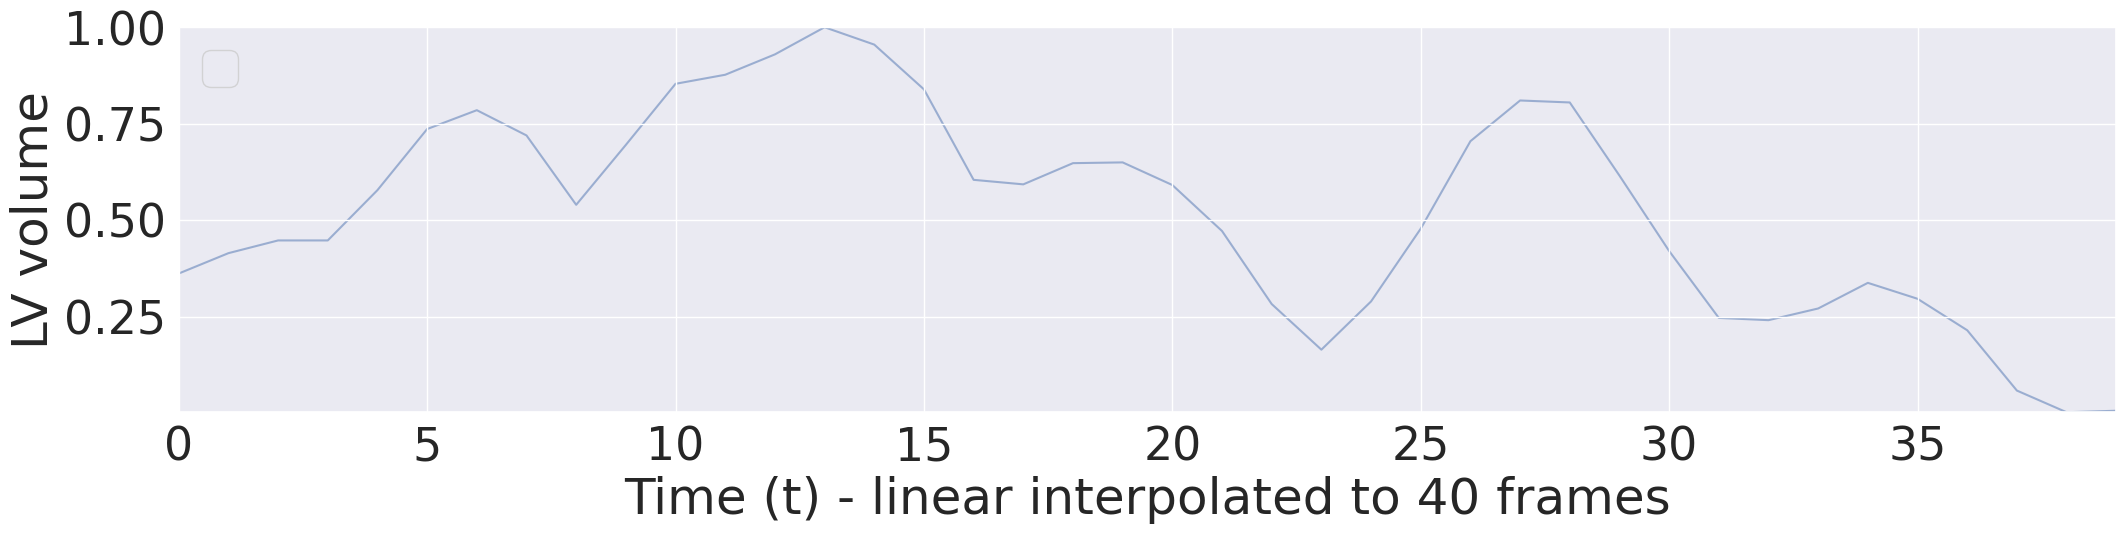

In [220]:
import seaborn as sb
import pandas as pd
ax1_label = 'LV volume'

sb.set_context('paper')
sb.set(font_scale=3)
fig, ax = plt.subplots(figsize=(25, 5))
ax.margins(0, 0)

outlier =  [335] # [ 284]
# [335, 349, 244, 318, 349, 244, 303, 351, 325 ] # [238, 251, 286, 303, 310, 335, 358], [233, 238, 284, 303, 335, 345, 354, 358, 359]

for n, vol in enumerate(vols_alignedscaled):
    if any(x == n+201 for x in outlier):
        _ = ax.plot(vol, alpha=0.5, zorder=0)

# df = pd.DataFrame(vols_alignedscaled).melt()
# _ = sb.lineplot(x='variable', y='value', data=df, color='blue', label=r'LV volume', ci='sd', err_style='bars',
#                 zorder=2, legend=False, ax=ax)
# _ = ax.set_title('Mean direction +/- SD - aligned at ED')
# pred_inds = np.array(pred_rerolled)
# _ = ax.set_xticks(np.rint(pred_inds.mean(axis=0)), minor=False)
_ = ax.set_xlabel('Time (t) - linear interpolated to 40 frames')
_ = ax.set_ylabel(ax1_label)
_ = ax.legend(loc='upper left')

### 3.1.3 LV BP Volume for SAX

In [ ]:
def get_bp_volume_curve(file, label=1, crop_x=0, crop_y=0):
    nifti = sitk.ReadImage(file)
    cmr_sequence = sitk.GetArrayFromImage(nifti)
    pixel_counts = []
    nifti_data = []
    if type(label) == int:
        label = [label]
    label_count = 0
    for i in range(nifti.GetSize()[-1]):
        timestep = nifti[:, :, :, i]
        data = sitk.GetArrayFromImage(timestep)
        dshape = data.shape
        start_x, end_x, start_y, end_y = crop_x , dshape[0] - (crop_x+20) , crop_y, dshape[1] - crop_y
        cropped_data = data[:, start_x:end_x, start_y+20:end_y]
        for l in label:
            count = np.sum(data == label)  # Count pixels for the specified label
            label_count = label_count + count
        whole_count = np.prod(data.shape)  
        pixel_counts.append(label_count/whole_count)
        nifti_data.append(cropped_data)
        label_count = 0

    stacked_data = np.stack(nifti_data, axis=-1)
    stacked_data = np.transpose(stacked_data, (3, 1, 2, 0))
    return stacked_data, pixel_counts

# 3.1.2 Detect abnormal curves

In [168]:
# Select folder with validation folder of nnU-Net
validation_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(validation_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [230]:
validation_path = validation_path_chooser.selected
file_regex =  'summary.json'
path_ = os.path.join(validation_path, file_regex)
validation_json = sorted(glob.glob(path_))[0]
print(validation_json)

/mnt/ssd/sarah/data/nnUNET/nnUNET_results/Dataset006_mnm2_fimh_singleFold/nnUNetTrainer_100epochs__nnUNetPlans__2d/fold_0/validation/summary.json


Mean validation Dice score across all patients and labels ([1]): 0.9604
Standard deviation of Dice scores: 0.0153

Patients with worst Dice scores for label(s) [1]:
Patient ID: 347, Dice: 0.9198
Patient ID: 351, Dice: 0.9200
Patient ID: 216, Dice: 0.9238
Patient ID: 318, Dice: 0.9250
Patient ID: 317, Dice: 0.9259
Patient ID: 298, Dice: 0.9271
Patient ID: 360, Dice: 0.9307
Patient ID: 325, Dice: 0.9314
Patient ID: 267, Dice: 0.9325
Patient ID: 334, Dice: 0.9326
Patient ID: 346, Dice: 0.9333
Patient ID: 297, Dice: 0.9339
Patient ID: 354, Dice: 0.9343
Patient ID: 239, Dice: 0.9358
Patient ID: 344, Dice: 0.9363
Patient ID: 289, Dice: 0.9365
Patient ID: 307, Dice: 0.9387
Patient ID: 263, Dice: 0.9387


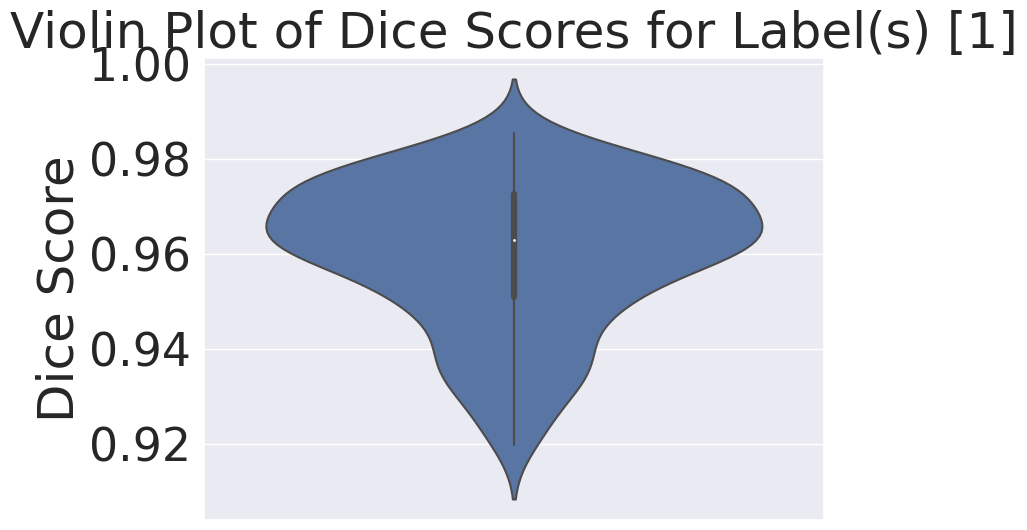

Mean validation Dice score across all patients and labels ([2]): 0.8852
Standard deviation of Dice scores: 0.0434

Patients with worst Dice scores for label(s) [2]:
Patient ID: 311, Dice: 0.7574
Patient ID: 359, Dice: 0.7604
Patient ID: 354, Dice: 0.7748
Patient ID: 209, Dice: 0.7786
Patient ID: 318, Dice: 0.7828
Patient ID: 242, Dice: 0.7849
Patient ID: 239, Dice: 0.7856
Patient ID: 241, Dice: 0.7899
Patient ID: 208, Dice: 0.7989
Patient ID: 238, Dice: 0.8120
Patient ID: 222, Dice: 0.8125
Patient ID: 307, Dice: 0.8127
Patient ID: 350, Dice: 0.8131
Patient ID: 289, Dice: 0.8147
Patient ID: 346, Dice: 0.8189
Patient ID: 347, Dice: 0.8195
Patient ID: 216, Dice: 0.8281
Patient ID: 245, Dice: 0.8285


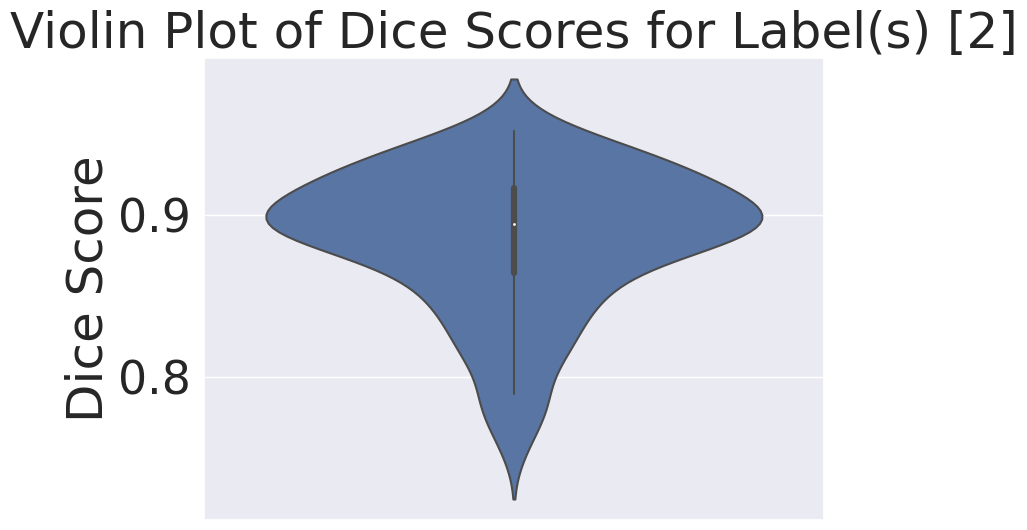

Mean validation Dice score across all patients and labels ([1, 2]): 0.9228
Standard deviation of Dice scores: 0.0272

Patients with worst Dice scores for label(s) [1, 2]:
Patient ID: 359, Dice: 0.8506
Patient ID: 311, Dice: 0.8527
Patient ID: 318, Dice: 0.8539
Patient ID: 354, Dice: 0.8545
Patient ID: 239, Dice: 0.8607
Patient ID: 242, Dice: 0.8624
Patient ID: 209, Dice: 0.8658
Patient ID: 241, Dice: 0.8684
Patient ID: 347, Dice: 0.8697
Patient ID: 208, Dice: 0.8707
Patient ID: 289, Dice: 0.8756
Patient ID: 307, Dice: 0.8757
Patient ID: 216, Dice: 0.8759
Patient ID: 346, Dice: 0.8761
Patient ID: 317, Dice: 0.8786
Patient ID: 351, Dice: 0.8798
Patient ID: 350, Dice: 0.8811
Patient ID: 222, Dice: 0.8861


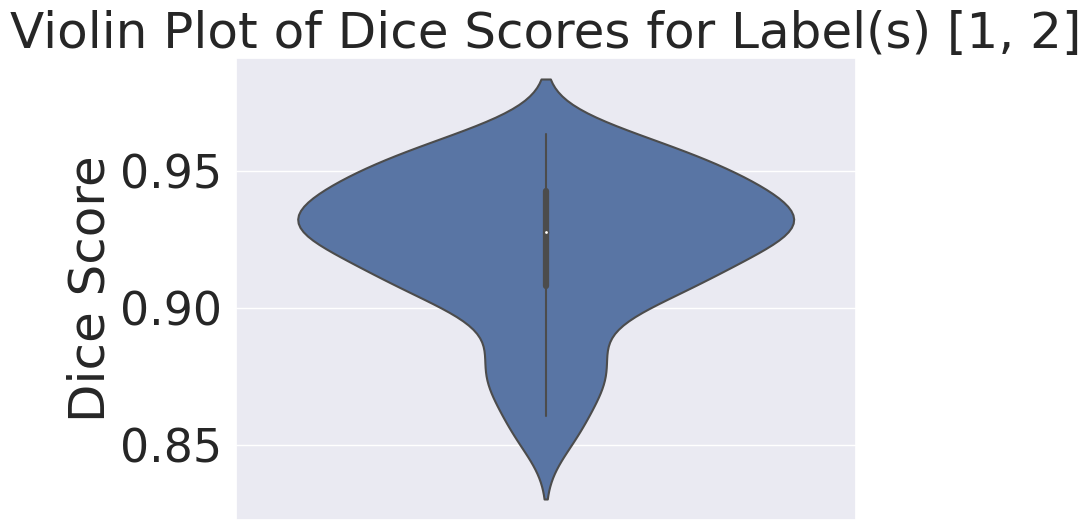

Mean validation Dice score across all patients and labels ([3]): 0.9117
Standard deviation of Dice scores: 0.0437

Patients with worst Dice scores for label(s) [3]:
Patient ID: 239, Dice: 0.5906
Patient ID: 336, Dice: 0.7818
Patient ID: 235, Dice: 0.8090
Patient ID: 231, Dice: 0.8101
Patient ID: 245, Dice: 0.8156
Patient ID: 238, Dice: 0.8260
Patient ID: 216, Dice: 0.8378
Patient ID: 317, Dice: 0.8447
Patient ID: 298, Dice: 0.8480
Patient ID: 330, Dice: 0.8538
Patient ID: 271, Dice: 0.8568
Patient ID: 301, Dice: 0.8615
Patient ID: 329, Dice: 0.8644
Patient ID: 325, Dice: 0.8648
Patient ID: 279, Dice: 0.8671
Patient ID: 311, Dice: 0.8679
Patient ID: 322, Dice: 0.8725
Patient ID: 307, Dice: 0.8732


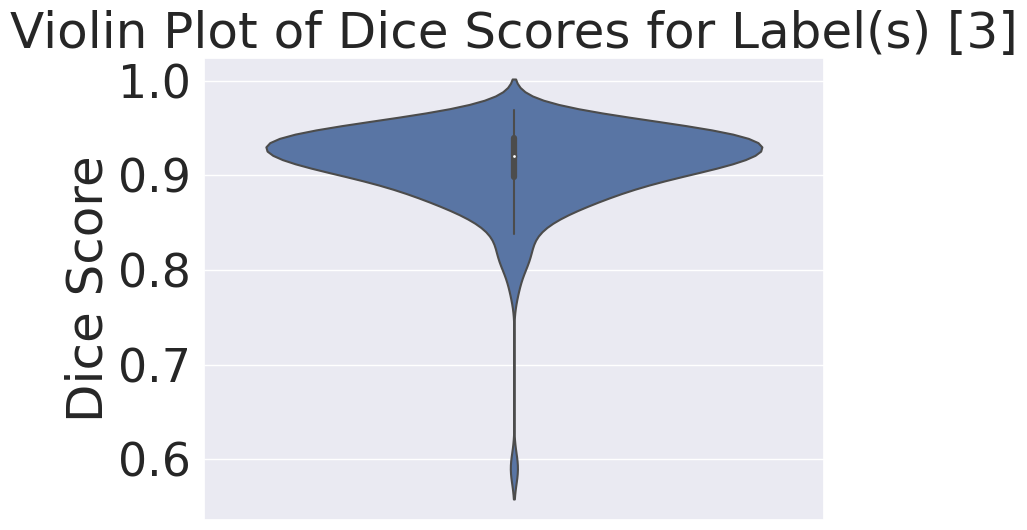

Mean validation Dice score across all patients and labels ([1, 2, 3]): 0.9191
Standard deviation of Dice scores: 0.0285

Patients with worst Dice scores for label(s) [1, 2, 3]:
Patient ID: 239, Dice: 0.7707
Patient ID: 311, Dice: 0.8578
Patient ID: 336, Dice: 0.8621
Patient ID: 216, Dice: 0.8632
Patient ID: 318, Dice: 0.8642
Patient ID: 238, Dice: 0.8660
Patient ID: 231, Dice: 0.8671
Patient ID: 317, Dice: 0.8673
Patient ID: 245, Dice: 0.8680
Patient ID: 209, Dice: 0.8693
Patient ID: 242, Dice: 0.8727
Patient ID: 354, Dice: 0.8732
Patient ID: 359, Dice: 0.8740
Patient ID: 307, Dice: 0.8749
Patient ID: 347, Dice: 0.8779
Patient ID: 325, Dice: 0.8790
Patient ID: 241, Dice: 0.8797
Patient ID: 208, Dice: 0.8800


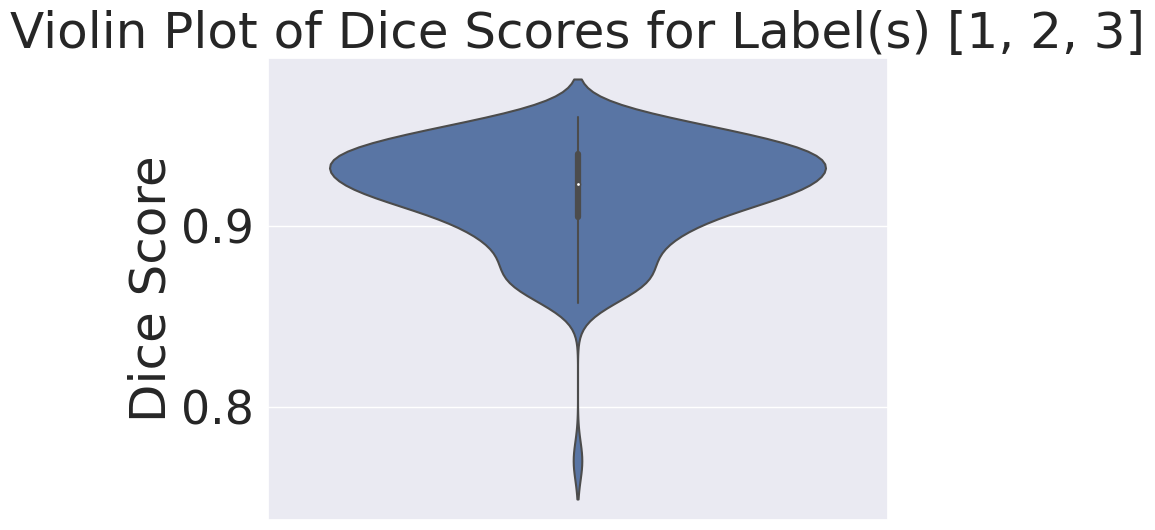

In [332]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


def extract_id_from_filename(filename):
    """Extract the patient ID from the filename."""
    filename = filename.split("/")[-1]
    match = re.search(r'(\d+)_', filename)
    return match.group(1) if match else None


def process_json(file_path, labels=[1]):
    """Process a JSON file and return aggregated patient scores."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    include_patients = [211, 213, 229, 233, 237, 240, 244, 249, 259, 272, 284, 303, 305, 331, 335, 345, 348, 349]

    patient_scores = defaultdict(list)
    
    for entry in data.get("metric_per_case", []):
        prediction_file = entry.get("prediction_file", "")
        patient_id = extract_id_from_filename(prediction_file)
        if not patient_id:
            continue
        
        if len(include_patients) > 0 and any([str(x) in str(patient_id) for x in include_patients]):
            continue
        metrics = entry.get("metrics", {})
        label_dice = np.mean([metrics.get(str(lbl), {}).get("Dice", 0) for lbl in labels])
        
        if label_dice > 0:
            patient_scores[patient_id].append(label_dice)
    # Compute the mean score for each patient
    summary_scores = {pid: np.mean(dices) for pid, dices in patient_scores.items()}

    return summary_scores, patient_scores


def summarize_patient_scores(file_path, labels=[1]):
    """Summarize patient scores from a single JSON file and compute overall stats."""
    summary_scores, patient_scores = process_json(file_path, labels)
    
    if not summary_scores:
        print("No valid scores found.")
        return
    
    # Calculate overall mean and standard deviation
    all_scores = list(summary_scores.values())
    mean_score = np.mean(all_scores)
    std_score = np.std(all_scores)
    
    print(f"Mean validation Dice score across all patients and labels ({labels}): {mean_score:.4f}")
    print(f"Standard deviation of Dice scores: {std_score:.4f}\n")
    
    # Sort and get the worst scores
    worst_scores = sorted(summary_scores.items(), key=lambda x: x[1])[:18]
    worst_scores_per_case = sorted(patient_scores.items(), key=lambda x: x[1])[:10]
    
    print(f"Patients with worst Dice scores for label(s) {labels}:")
    for patient_id, dice in worst_scores:
        print(f"Patient ID: {patient_id}, Dice: {dice:.4f}")
    
    # print(f"Patients with worst Dice scores for each frame and for label(s) {labels}:")
    # for patient_id, dice in worst_scores_per_case:
    #     print(f"Patient ID: {patient_id}, Dice_ED: {dice[0]:.4f}, Dice_ES: {dice[1]:.4f}")
    
    # Plot the scores
    plt.figure(figsize=(8, 6))
    sns.violinplot(y=all_scores)
    plt.title(f"Violin Plot of Dice Scores for Label(s) {labels}")
    plt.ylabel("Dice Score")
    plt.show()


# Example usage
file_path = validation_json
summarize_patient_scores(file_path)
summarize_patient_scores(file_path, labels=[2])
summarize_patient_scores(file_path, labels=[1, 2])
summarize_patient_scores(file_path, labels=[3])
summarize_patient_scores(file_path, labels=[1, 2, 3])

In [320]:
from scipy.signal import find_peaks
from scipy.spatial.distance import euclidean
from scipy.fft import fft
from fastdtw import fastdtw

def add_time_steps(curve):
    time_steps = np.arange(len(curve))
    return np.column_stack((curve, time_steps))


def detect_abnormal_curves(curves, threshold_peaks=2, distance_threshold=0.3):
    num_curves = curves.shape[0]
    time_points = curves.shape[1]
    
    # Calculate the mean curve
    mean_curve = np.mean(curves, axis=0)
    
    abnormal_curves = []
    
    for i in range(num_curves):
        curve = curves[i]
        # 1. Peak detection
        peaks, _ = find_peaks(curve, height=0.2)
        
        # 2. Distance to mean curve (Dynamic Time Warping)
        distance, _ = fastdtw(curve, mean_curve)
        normalized_distance = distance / time_points
        
        # 3. Fourier analysis for smoothness (high-frequency content)
        freq_spectrum = np.abs(fft(curve))
        high_freq_power = np.sum(freq_spectrum[int(len(freq_spectrum) * 0.2):])
        
        # Flag curve as abnormal if it has too many peaks or is too far from the mean
        if len(peaks) >= threshold_peaks or normalized_distance > distance_threshold:
            abnormal_curves.append(i)
        
    return abnormal_curves, mean_curve

In [236]:
def detect_abnormal_curves_per_pathology(info_df, results, pid="SUBJECT_CODE", group_by="DISEASE"):
    info_df[pid] = info_df[pid].astype(str)
    results_df[pid] = results_df['patient'].apply(extract_patient_id).astype(str)
    merged_df = pd.merge(info_df, results_df,on=pid, how='inner')
    # Group the data by pathology
    for pathology, group in merged_df.groupby(group_by):
        abnormal_indices, mean_curve  = [], []
        if group.empty:
            continue
        print(pathology)
        volume_curves = np.array(group['volume_aligned'].tolist())
        
        # abnormal_indices, mean_curve = detect_abnormal_curves(curve_array_with_time)
        abnormal_indices, mean_curve = detect_abnormal_curves(volume_curves, threshold_peaks=3, distance_threshold=0.3)

        plt.plot(mean_curve, label='Mean Curve', color='blue')
        for idx in abnormal_indices:
            plt.plot(curve_array[idx], alpha=0.6)
        plt.legend()
        plt.show()
        

# path_info = os.path.join(masks_path, "dataset_information.csv")
# path_info = sorted(glob.glob(path_info))[0]
# df_info = pd.read_csv(path_info)

# plot_volumes_per_pathology(df_info, results_df)

ARR


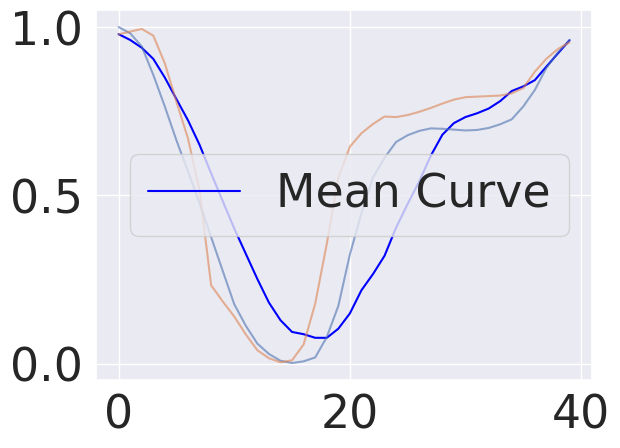

CIA


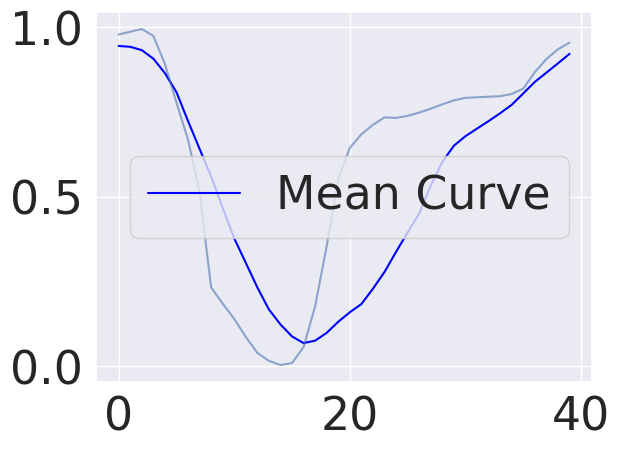

FALL


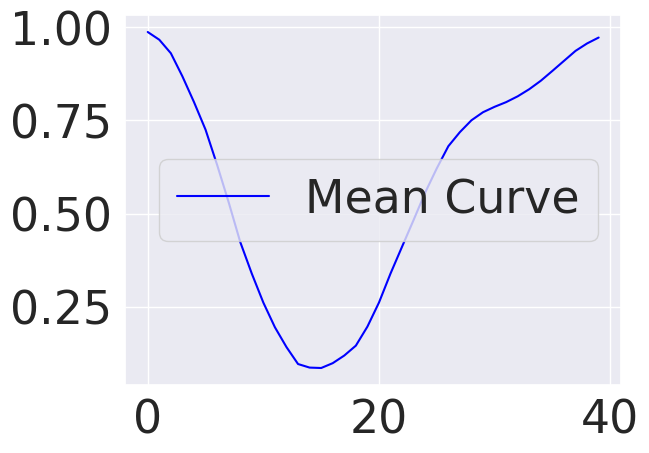

HCM


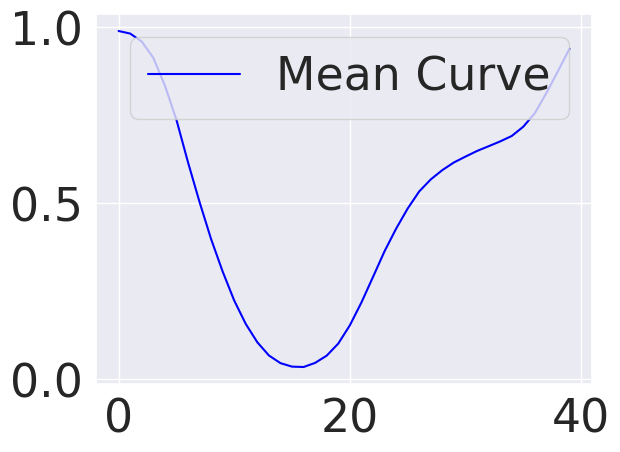

LV


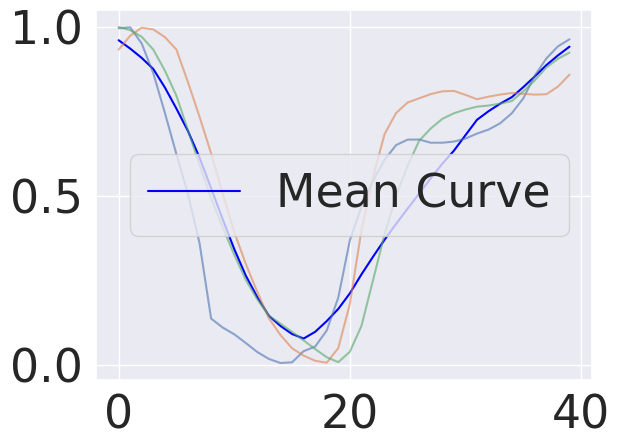

NOR


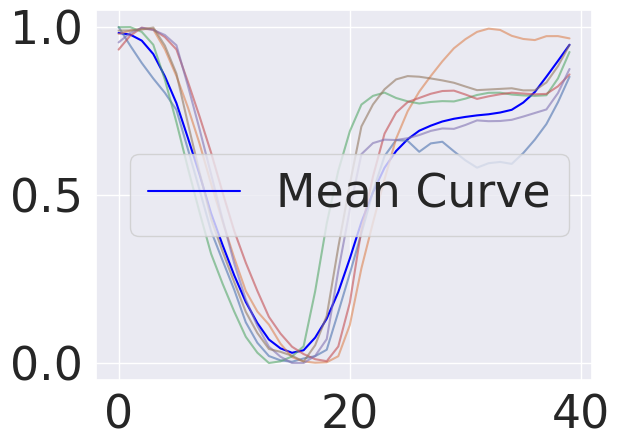

RV


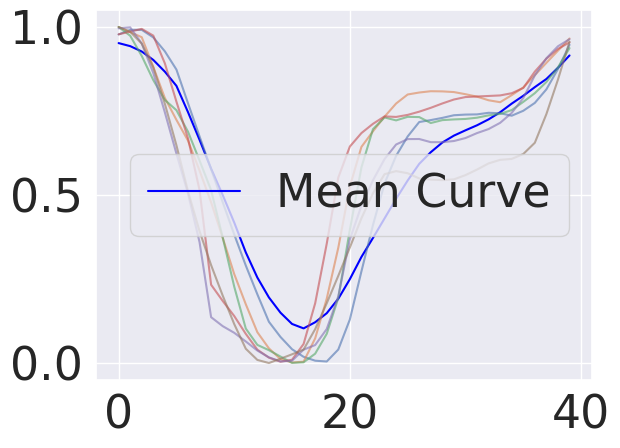

TRI


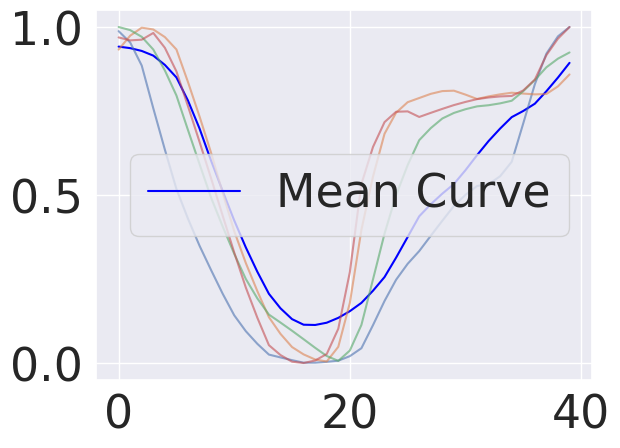

In [149]:
detect_abnormal_curves_per_pathology(df_info, results_df)

# 3.1.2 CFD and plot per patient

In [42]:
cfd_df = df[['patient', 'ED', 'ES']]
cfd_df.to_csv(os.path.join(masks_path, 'cfd.csv'), index=False)

gt_df = df[['patient', 'ED_gt', 'ES_gt']]
gt_df.to_csv(os.path.join(masks_path, 'gt_phases.csv'), index=False)

pred_df = df[['patient', 'ED#', 'ES#']]
pred_df.to_csv(os.path.join(masks_path, 'pred_phases.csv'), index=False)

KeyError: "None of [Index(['patient', 'ED', 'ES'], dtype='object')] are in the [columns]"

plot_3d_vol sliced first axis 25 by 1


/mnt/ssd/sarah/git/cmr-LAX-phase-detection/src/visualization/Visualize.py:463: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=0)


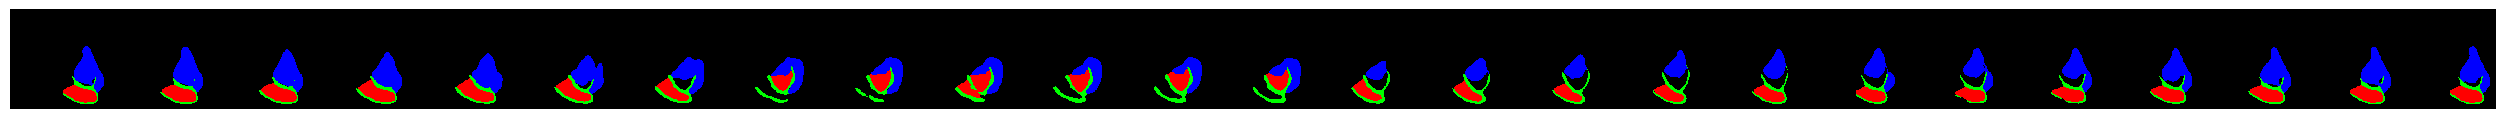

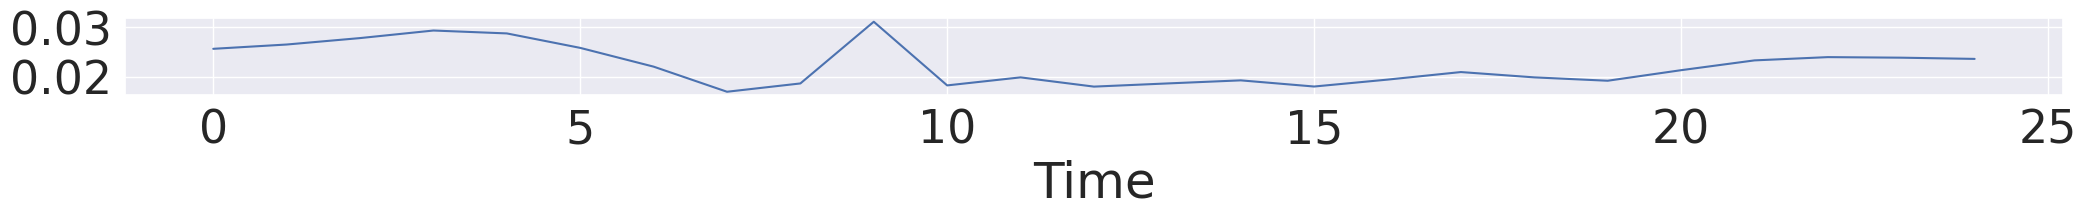

[9 0 7 0 0]


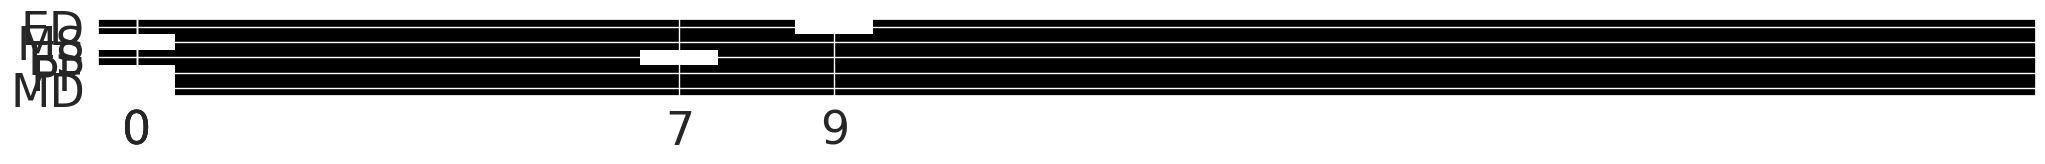

[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 ...


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]]


In [102]:
from src.visualization.Visualize import show_2D_or_3D
def load_mask(path):
    sitk_mask = sitk.ReadImage(path)
    mask = sitk.GetArrayFromImage(sitk_mask)
    return mask

# Settings
masks = masked_niftis[134]
img = niftis[134]
if type(img) == type(""):
    img = load_mask(img)
crop_x = 25
crop_y = 0
weight = 1
phases = ['ED', 'MS', 'ES', 'PF', 'MD']

stacked_masks_data, label_pixel_counts = get_bp_volume_curve(masks) #, crop_x=crop_x, crop_y=crop_y)
cardiac_cycle_length=len(stacked_masks_data)
figsize = (cardiac_cycle_length, 1)

fig = show_2D_or_3D(img = img[...,0], mask= stacked_masks_data[...,0], allow_slicing=True)
ax = fig.get_axes()[0]
_ = ax.set_ylabel('Masks \n2d+t') #\nmid
plt.show()

plt.figure(figsize=figsize)
plt.plot(label_pixel_counts)
plt.xlabel('Time')
plt.show()

ed_bp = np.argmin(label_pixel_counts)
es_bp = np.argmax(label_pixel_counts)

pred_bp = np.array([es_bp, 0, ed_bp, 0, 0]) 
print(pred_bp)
onehot_pred = np.zeros((pred_bp.size, cardiac_cycle_length)) # cardiac_cycle_length_
onehot_pred[np.arange(pred_bp.size), pred_bp] = weight
fig, ax = plt.subplots(figsize=figsize)
ax.set_xticks(pred_bp, minor=False)
ax.set_yticks([0, 1, 2, 3, 4], minor=False)
ax.set_yticklabels(phases, rotation=0)
_ = plt.imshow(onehot_pred,aspect='auto', cmap='bone')
_ = ax.set_yticklabels(phases)
ax.margins(0,0)
plt.show()

print(img)

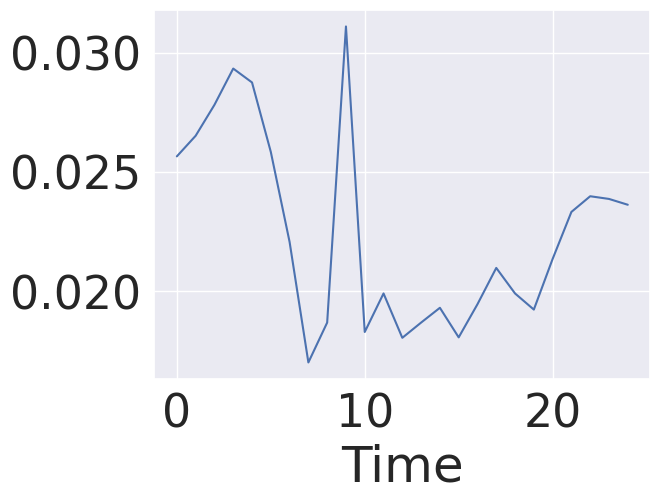

In [87]:
plt.plot(label_pixel_counts)
plt.xlabel('Time')
plt.show()

## 3.2 RV Volume Curves

In [33]:
results_rv = []
imgs_rv = []
volume_curves_rv = []
gt_inds_rv = []
pred_inds_rv = []
cardiac_cycle_len_list_rv = []

# Iterate through each image path and corresponding ground truth data
for img_path, gt in zip(masked_niftis, gt_df.itertuples(index=False)):
    img, pixel_counts = get_bp_volume_curve(img_path, label=3)
    cardiac_cycle_len = img.shape[0]
    name = img_path.split('/')[-1]
    es_bp = np.argmin(pixel_counts)
    ed_bp = np.argmax(pixel_counts)
    
    # Ground truth values from the DataFrame
    ed_gt = gt._1
    es_gt = gt._3
    
    # Calculate corrected frame difference (CFD)
    ed_cfd = cfd(ed_bp, ed_gt, cardiac_cycle_len)
    es_cfd = cfd(es_bp, es_gt, cardiac_cycle_len)
    
    # Append results to the list
    results_rv.append({
        'patient': name,
        'ED#': ed_bp,
        'ED_gt': ed_gt,
        'ED': ed_cfd,
        'ES#': es_bp,
        'ES_gt': es_gt,
        'ES': es_cfd
    })
    
    # Append volume curve list
    volume_curves_rv.append(pixel_counts)
    
    # Append gt and pred list 
    gt_inds_rv.append([ed_gt, es_gt])
    pred_inds_rv.append([ed_bp, es_bp])
    
    # Append cardiac cycle length list
    cardiac_cycle_len_list_rv.append(len(pixel_counts))
    
    imgs_rv.append(img)

# Create a DataFrame from the results list
df_rv = pd.DataFrame(results_rv)
# Display the DataFrame
print(df_rv)
patient = df_rv.iloc[11]
print(patient)

                      patient  ED#  ED_gt  ED  ES#  ES_gt  ES
0    201_LA_CINE_masks.nii.gz   24     24   0    8      9   1
1    202_LA_CINE_masks.nii.gz   24      0   1    9      9   0
2    203_LA_CINE_masks.nii.gz   19      0   1    7      8   1
3    204_LA_CINE_masks.nii.gz   22      0   2    8      9   1
4    205_LA_CINE_masks.nii.gz   19      0   2    8      8   0
..                        ...  ...    ...  ..  ...    ...  ..
155  356_LA_CINE_masks.nii.gz   24     24   0   10      9   1
156  357_LA_CINE_masks.nii.gz    0      4   4   14     16   2
157  358_LA_CINE_masks.nii.gz   24      1   2   13     10   3
158  359_LA_CINE_masks.nii.gz   23     24   1   11     11   0
159  360_LA_CINE_masks.nii.gz    1     24   2    9      8   1

[160 rows x 7 columns]
patient    212_LA_CINE_masks.nii.gz
ED#                               0
ED_gt                             0
ED                                0
ES#                               7
ES_gt                             8
ES              

In [34]:
cfd_df_rv = df_rv[['patient', 'ED', 'ES']]
cfd_df_rv.to_csv(os.path.join(masks_path, 'cfd_rv.csv'), index=False)

gt_df_rv = df_rv[['patient', 'ED_gt', 'ES_gt']]
gt_df_rv.to_csv(os.path.join(masks_path, 'gt_phases_rv.csv'), index=False)

pred_df_rv = df_rv[['patient', 'ED#', 'ES#']]
pred_df_rv.to_csv(os.path.join(masks_path, 'pred_phases_rv.csv'), index=False)

In [35]:
from src.visualization.Visualize import show_2D_or_3D

# Settings
masks = masked_niftis[1]
img = niftis[1]
crop_x = 25
crop_y = 0
weight = 1
phases = ['ED', 'MS', 'ES', 'PF', 'MD']

stacked_masks_data, label_pixel_counts = get_bp_volume_curve(masks, label=3, crop_x=crop_x, crop_y=crop_y)
cardiac_cycle_length=len(stacked_masks_data)
figsize = (cardiac_cycle_length, 1)

fig = show_2D_or_3D(img = temp[...,0], mask= stacked_masks_data[...,0], allow_slicing=True)
ax = fig.get_axes()[0]
_ = ax.set_ylabel('Masks \n2d+t') #\nmid
plt.show()

plt.figure(figsize=figsize)
plt.plot(label_pixel_counts)
plt.xlabel('Time')
plt.show()

ed_bp = np.argmin(label_pixel_counts)
es_bp = np.argmax(label_pixel_counts)

pred_bp = np.array([es_bp, 0, ed_bp, 0, 0]) 
print(pred_bp)
onehot_pred = np.zeros((pred_bp.size, cardiac_cycle_length)) # cardiac_cycle_length_
onehot_pred[np.arange(pred_bp.size), pred_bp] = weight
fig, ax = plt.subplots(figsize=figsize)
ax.set_xticks(pred_bp, minor=False)
ax.set_yticks([0, 1, 2, 3, 4], minor=False)
ax.set_yticklabels(phases, rotation=0)
_ = plt.imshow(onehot_pred,aspect='auto', cmap='bone')
_ = ax.set_yticklabels(phases)
ax.margins(0,0)
plt.show()

print(img)

NameError: name 'temp' is not defined

In [ ]:
plt.plot(label_pixel_counts)
plt.xlabel('Time')
plt.show()

In [ ]:
results_comb = []
imgs_comb = []
volume_curves_comb = []
gt_inds_comb = []
pred_inds_comb = []
cardiac_cycle_len_list_comb= []

# Iterate through each image path and corresponding ground truth data
for img_path, gt in zip(masked_niftis, gt_df.itertuples(index=False)):
    img, pixel_counts = get_bp_volume_curve(img_path, label=[1,3])
    cardiac_cycle_len = img.shape[0]
    name = img_path.split('/')[-1]
    es_bp = np.argmin(pixel_counts)
    ed_bp = np.argmax(pixel_counts)
    
    # Ground truth values from the DataFrame
    ed_gt = gt._1
    es_gt = gt._3
    
    # Calculate corrected frame difference (CFD)
    ed_cfd = cfd(ed_bp, ed_gt, cardiac_cycle_len)
    es_cfd = cfd(es_bp, es_gt, cardiac_cycle_len)
    
    # Append results to the list
    results_comb.append({
        'patient': name,
        'ED#': ed_bp,
        'ED_gt': ed_gt,
        'ED': ed_cfd,
        'ES#': es_bp,
        'ES_gt': es_gt,
        'ES': es_cfd
    })
    
    # Append volume curve list
    volume_curves_comb.append(pixel_counts)
    
    # Append gt and pred list 
    gt_inds_comb.append([ed_gt, es_gt])
    pred_inds_comb.append([ed_bp, es_bp])
    
    # Append cardiac cycle length list
    cardiac_cycle_len_list_comb.append(len(pixel_counts))
    
    imgs_comb.append(img)

# Create a DataFrame from the results list
df_comb = pd.DataFrame(results_comb)
# Display the DataFrame
print(df_comb)
patient = df_comb.iloc[11]
print(patient)

In [ ]:
from src.visualization.Visualize import plot_pfd_per_phase_as_violin

plot_pfd_per_phase_as_violin(df[['ED', 'ES']])
plot_pfd_per_phase_as_violin(df_comb[['ED', 'ES']])
plot_pfd_per_phase_as_violin(df_rv[['ED', 'ES']])

## 3.3 Calculate simulated Volume

In [218]:
def calculate_LV_volume(msk):
    volume_curve = []
    A, msk_array, spacing = get_area_by_label(msk)
    for t in range(msk_array.shape[0]):
        L = calculate_LV_len(msk_array[t], spacing) # * spacing
        print(L)
        if L > 0:
            volume_LV = 0.85 * A[t]**2/L
            volume_curve.append(volume_LV/1000)
        else:
            print(msk, t)
    return volume_curve

def get_phases_from_volume(volume_curve):
    es_pred = np.argmin(volume_curve)
    ed_pred = np.argmax(volume_curve)
    return ed_pred, es_pred

def create_bp_volume_df(volume_curves, gt_df):
    results = []
    for curve, gt in zip(volume_curves, gt_df.itertuples(index=False)):
        cardiac_cycle_len = len(curve)
        ed_pred, es_pred = get_phases_from_volume(curve)
        # Ground truth values from the DataFrame
        ed_gt = gt._1
        es_gt = gt._3
        name = gt.patient
        
        # Calculate corrected frame difference (CFD)
        ed_cfd = cfd(ed_pred, ed_gt, cardiac_cycle_len)
        es_cfd = cfd(es_pred, es_gt, cardiac_cycle_len)

        # Append results to the list
        results.append({
            'patient': name,
            'ED#': ed_pred,
            'ED_gt': ed_gt,
            'ED': ed_cfd,
            'ES#': es_pred,
            'ES_gt': es_gt,
            'ES': es_cfd
        })
    # Create a DataFrame from the results list
    df = pd.DataFrame(results)
    return df

In [222]:
import scipy.ndimage as ndimage

def get_area_by_label(file, label=1):
    nifti = sitk.ReadImage(file)
    cmr_sequence = sitk.GetArrayFromImage(nifti)
    pixel_counts = []
    nifti_data = []
    
    spacing = nifti.GetSpacing()[0] * nifti.GetSpacing()[1] 
    
    for i in range(nifti.GetSize()[-1]):
        timestep = nifti[:, :, :, i]
        data = sitk.GetArrayFromImage(timestep)
        dshape = data.shape
        count = np.sum(data == label)  # Count pixels for the specified label
        area = count * spacing
        pixel_counts.append(area)
        nifti_data.append(data)
        
    return np.array(pixel_counts), np.array(nifti_data), [ nifti.GetSpacing()[0], nifti.GetSpacing()[1] ]

def calculate_LV_len(mask, spacing, show_figure=False):
    if mask.ndim > 2:
        mask = mask[0,...]
    
    lv_boundary, myo_boundary, endocardium_boundary = get_mask_contours(mask)
    lvip = find_LVIP(lv_boundary, myo_boundary)

    if len(lvip[0]) >= 2:
        mitan_point = find_mitral_annulus(lvip)
    else:
        print("Not enough LVIP points found")
        mitan_point = None
        
    if mitan_point:
        apex_point = find_apex(mitan_point, endocardium_boundary)
    else:
        print("Mitral annulus point not available")
        apex_point = None
    
    if show_figure:
        show_mask_with_points(mask, lvip, mitan_point, apex_point)
        
    if mitan_point and apex_point:
        # Calculate distance between mitral annulus point and apex point
        LV_len = np.sqrt(((apex_point[0] - mitan_point[0])*spacing[0])**2 + ((apex_point[1] - mitan_point[1])*spacing[1])**2)
        return LV_len
    else:
        print("Calculation of length L between apex and mitral annulus not possible.")
        return -1
    
    
def show_mask_with_points(mask, lvip, mitan_point, apex_point):
    # Plot the results
    plt.figure(figsize=(6, 6))
    cropped_mask = mask[mask.shape[0] // 4: 3 * mask.shape[0] // 4, mask.shape[1] // 4: 3 * mask.shape[1] // 4]
    plt.imshow(cropped_mask, cmap='gray')
    
    lvip_cropped = (lvip[0] - mask.shape[0] // 4, lvip[1] - mask.shape[1] // 4)
    plt.scatter(lvip_cropped[1], lvip_cropped[0], color='orangered', label='LV intersection points', marker='x', s=100, linewidths=2)  # LVIP points in red

    if mitan_point:
        mitan_point_cropped = (mitan_point[0] - mask.shape[0] // 4, mitan_point[1] - mask.shape[1] // 4)
        plt.scatter(mitan_point_cropped[1], mitan_point_cropped[0], color='lawngreen', label='Mitral Annulus point', marker='x', s=100, linewidths=2)  # MAP point in green

    if apex_point:
        apex_point_cropped = (apex_point[0] - mask.shape[0] // 4, apex_point[1] - mask.shape[1] // 4)
        plt.scatter(apex_point_cropped[1], apex_point_cropped[0], color='cyan', label='Apex point', marker='x', s=100, linewidths=2)  # Apex point in blue

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


def get_mask_contours(mask):
    lv_mask = (mask == 1).astype(np.uint8)
    myo_mask = (mask == 2).astype(np.uint8)

    lv_boundary = get_boundary(lv_mask)
    myo_boundary = get_boundary(myo_mask)  
    
    endocardium_boundary = np.where((myo_boundary == 1) & (lv_mask == 1))
    
    return lv_boundary, myo_boundary, endocardium_boundary
 

def get_boundary(single_mask, structure=np.ones((3, 3))):
    boundary = ndimage.binary_dilation(single_mask, structure=structure) - single_mask
    return boundary
 

def find_LVIP(lv_boundary, myo_boundary):
    # Find the intersection points where LV and MYO boundaries meet (LVIP points)
    lvip = np.where((lv_boundary == 1) & (myo_boundary == 1))
    if len(lvip[0]) < 2:
        new_myo_boundary = get_boundary(myo_boundary, structure=np.ones((6,6)))
        lvip = np.where((lv_boundary == 1) & (new_myo_boundary == 1))
        
    return [lvip[0], lvip[-1]]


def find_mitral_annulus(lvip):
    lvip_1 = (lvip[0][0], lvip[1][0])  # First LVIP point
    lvip_2 = (lvip[0][-1], lvip[1][-1])  # Last LVIP point

    # Calculate the Mitral Annulus Point (MAP) - midpoint between LVIP1 and LVIP2
    mitan_point = ((lvip_1[0] + lvip_2[0]) // 2, (lvip_1[1] + lvip_2[1]) // 2)

    return mitan_point


def find_apex(mitan_point, endocardium_boundary):
    # Get MYO boundary points and calculate distances of each boundary point from the MAP
    distances = np.sqrt((endocardium_boundary[0] - mitan_point[0])**2 + (endocardium_boundary[1] - mitan_point[1])**2)

    # Find the index of the furthest point -> Apex point is the furthest boundary point
    furthest_point_idx = np.argmax(distances)
    apex_point = (endocardium_boundary[0][furthest_point_idx], endocardium_boundary[1][furthest_point_idx])
    
    return apex_point

/mnt/ssd/sarah/data/mnm2/imported_LAX_2D_with_masks/lax/009_LA_CINE_masks.nii.gz


/tmp/ipykernel_3929924/1840602191.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


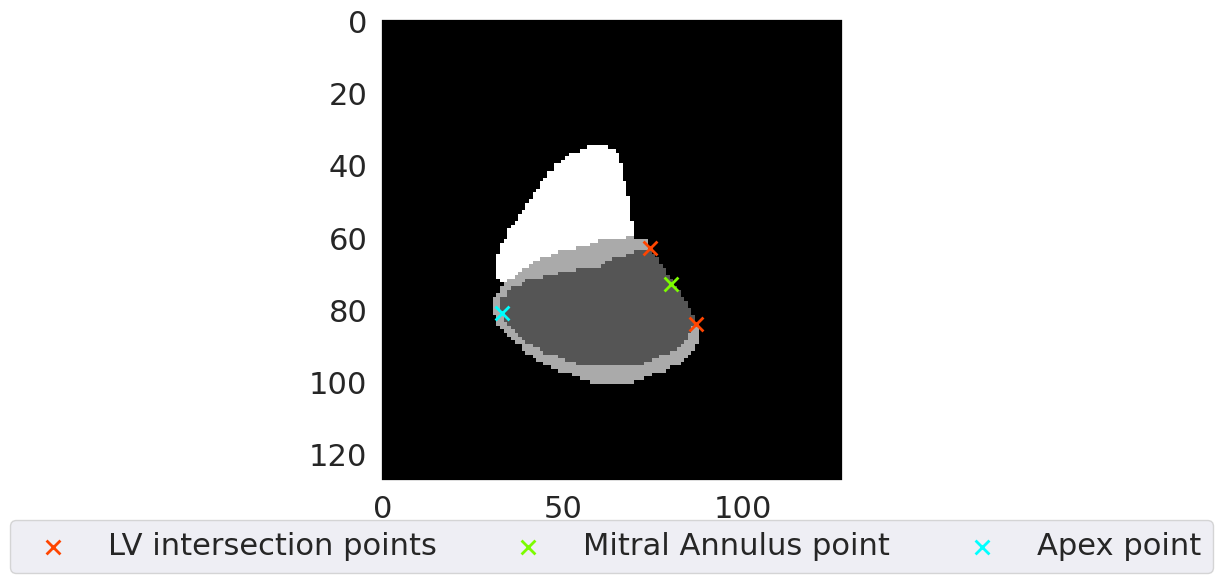

3583.53371731676
81.9454889206588


In [223]:
pid = 8
msk = masked_niftis[pid]
img = niftis[pid]
ed_step =2
print(msk)

A, msk_array, spacing = get_area_by_label(msk)
ed_L = calculate_LV_len(msk_array[ed_step], spacing, show_figure=True)
# ed_L = ed_L * spacing
print(A[ed_step])
print(ed_L)


In [224]:
bp_volume_curves = []
for msk in masked_niftis:
    curve = calculate_LV_volume(msk)
    bp_volume_curves.append(curve)

87.03309600415442
85.07627464731652
83.37510349045459
81.43921805125173
80.25159434399986
76.86708649358815
75.17663935772339
72.14867744232907
71.79978405466227
70.11357041516726
70.11357041516726
70.11357041516726
72.9225211262713
75.17663935772339
80.56389427736856
83.64043280279645
83.64043280279645
83.94012548132281
83.64043280279645
83.64043280279645
83.94012548132281
85.63007235569661
87.64196301895906
87.64196301895906
88.73072480185206
81.07564829798893
79.3631729399071
79.3631729399071
77.5177032604487
72.51626436566735
70.49177042206227
67.23124254615381
67.12129767692763
63.80431216902814
63.68845169179229
63.61883412495659
63.68845169179229
67.05524422709765
68.83789862264996
72.21007187474792
74.22750116672998
75.70530045137116
75.70530045137116
75.70530045137116
75.80279604933719
75.80279604933719
77.5177032604487
79.23277918663814
79.23277918663814
79.23277918663814
96.63570953092297
96.31417662010509
91.16124720953701
87.92801182020224
84.5013635748627
81.0756425940265

In [225]:
# Display the DataFrame
df = create_bp_volume_df(bp_volume_curves, gt_df)
print(df)
patient = df.iloc[0]
print(patient)

                patient  ED#  ED_gt  ED  ES#  ES_gt  ES
0    001_LA_CINE.nii.gz   23     23   0    9      8   1
1    002_LA_CINE.nii.gz   24     23   1    9      8   1
2    003_LA_CINE.nii.gz   23     22   1   10      8   2
3    004_LA_CINE.nii.gz    0     24   1    8      7   1
4    005_LA_CINE.nii.gz   22     23   1    7      6   1
..                  ...  ...    ...  ..  ...    ...  ..
355  356_LA_CINE.nii.gz   24     24   0    9      9   0
356  357_LA_CINE.nii.gz    5      2   3   15     15   0
357  358_LA_CINE.nii.gz    1      0   1   13      9   4
358  359_LA_CINE.nii.gz    2      3   1   11     14   3
359  360_LA_CINE.nii.gz    0     24   1   10      9   1

[360 rows x 7 columns]
patient    001_LA_CINE.nii.gz
ED#                        23
ED_gt                      23
ED                          0
ES#                         9
ES_gt                       8
ES                          1
Name: 0, dtype: object


mean overall
 mean     1.37
SD       1.58
median   1.00
dtype: float64
    mean   SD  median
ED  1.43 1.78    1.00
ES  1.31 1.39    1.00


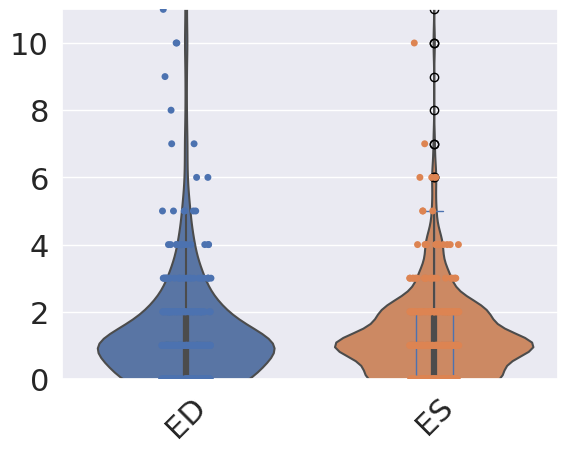

In [295]:
from src.visualization.Visualize import plot_pfd_per_phase_as_violin
df.to_csv(os.path.join(masks_path, "volume_based_phase_detection.csv"))
plot_pfd_per_phase_as_violin(df[['ED', 'ES']])

## 3.4 SAX Volume

In [116]:
from ipyfilechooser import FileChooser
data_path_chooser = FileChooser(os.path.join(os.getcwd(),''), '')
display(data_path_chooser)

FileChooser(path='/mnt/ssd/sarah/git/cmr-LAX-phase-detection', filename='', title='', show_hidden=False, selec…

In [30]:
data_path = data_path_chooser.selected
file_regex =  'dataset/*/*_SA_*gt.nii.gz' 
path_sax = os.path.join(data_path, file_regex)
sax_masked_niftis = sorted(glob.glob(path_sax))
print(len(sax_masked_niftis))

720


In [31]:
sax_masked_niftis[0]

'/mnt/ssd/sarah/data/MnM2/dataset/001/001_SA_ED_gt.nii.gz'

In [233]:
from src.data.Dataset import calc_vol_along_t_3D

def volume_from_path(sax_mask_path):
    try:
        sax_nifti = sitk.ReadImage(sax_mask_path)
        sax_mask = sitk.GetArrayFromImage(sax_nifti)
        volume = calc_vol_along_t_3D(sax_mask, label=1, spacing=sax_nifti.GetSpacing())
        return volume
    except Exception as e:
        return -1

def calculate_relative_error_volume_ration(sax_ed, sax_es, lax_ed, lax_es):
    if lax_ed < lax_es:
        return -1
    r_lax = lax_es/lax_ed
    r_sax = sax_es/sax_ed
    
    # print(f"\nRatio lax: {r_lax} sax: {r_sax}")
    error = abs(r_lax-r_sax)/abs(r_sax)
    
    return error

def calculate_relative_error_volume(sax, lax):
    # print(f"\nRatio lax: {r_lax} sax: {r_sax}")
    error = abs(lax-sax)/abs(sax)
    
    return error

In [293]:
sax_pid = 1
sax_volume_ed = sum(volume_from_path(sax_masked_niftis[sax_pid*2]))
sax_volume_es = sum(volume_from_path(sax_masked_niftis[sax_pid*2+1]))
print(f'Patient {sax_masked_niftis[sax_pid*2+1].split("/")[-2]}\nSAX ED Volume: {sax_volume_ed} ES Volume: {sax_volume_es}\nRatio: {sax_volume_es/sax_volume_ed}')

lax_pid = df.iloc[sax_pid][0].split("_")[0]
lax_ed_volume = bp_volume_curves[sax_pid][df.iloc[sax_pid]['ED_gt']]
lax_es_volume = bp_volume_curves[sax_pid][df.iloc[sax_pid]['ES_gt']]
print(f'\nPatient {df.iloc[sax_pid][0].split("_")[0]}\nEstimated LAX ED volume: {lax_ed_volume} ES volume: {lax_es_volume}\nRation: {lax_es_volume/lax_ed_volume}')

print(f"\nRelative ration error: {calculate_relative_error_volume_ration(sax_volume_ed, sax_volume_es, lax_ed_volume, lax_es_volume)}")

Patient 002
SAX ED Volume: 112.83823428086599 ES Volume: 37.17205647955886
Ratio: 0.32942784612380394

Patient 002
Estimated LAX ED volume: 119.5563403538633 ES volume: 48.671994746669796
Ration: 0.40710509039177883

Relative ration error: 0.23579440894860668


patient    002_LA_CINE.nii.gz
ED#                        24
ED_gt                      23
ED                          1
ES#                         9
ES_gt                       8
ES                          1
Name: 1, dtype: object


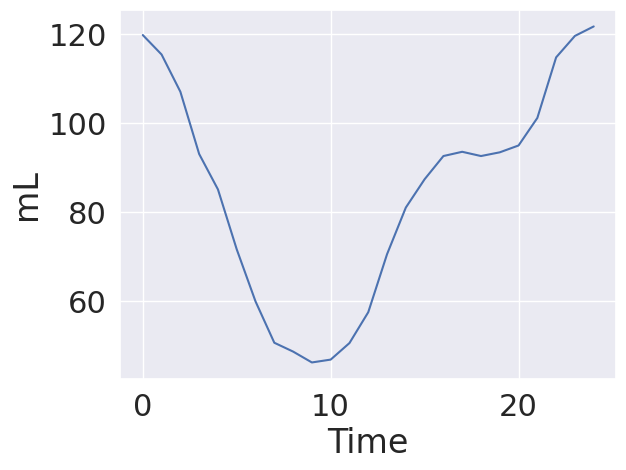

[119.75185077652057, 115.37978109391202, 107.02103535013974, 93.04082411653776, 85.08928384921441, 71.62919894506695, 59.93554423953744, 50.65678327616569, 48.671994746669796, 46.23182347732658, 46.87199353866916, 50.586048202461235, 57.51199014279351, 70.53262613556055, 81.01189098882519, 87.37335185331854, 92.58206383651199, 93.53700402610748, 92.58206383651199, 93.41669914799267, 94.95281644754763, 101.1360407501895, 114.73897543292458, 119.5563403538633, 121.68174479119799]


In [294]:
curve = bp_volume_curves[sax_pid]
patient = df.iloc[sax_pid]
print(patient)
plt.plot(curve)
plt.xlabel('Time')
plt.ylabel('mL')
plt.show()
print(curve)

## 3.5 Relation LAX & SAX Volume

In [241]:
def print_relative_error(relative_error_all, name="Ratio"):
    print(f"--------------------------\nRelative error for {name}")
    xs_error = sum( relative_error_all <= 0.01)
    print(f"Number of cases with very small error (<1%): {xs_error}")
    s_error = sum( relative_error_all <= 0.05) - xs_error
    print(f"Number of cases with small error (1-5%): {s_error}")
    m_error = sum( relative_error_all <= 0.1) - xs_error - s_error
    print(f"Number of cases with moderate error (5-10%): {m_error}")
    xl_error = sum(relative_error_all > 0.2)
    l_error = sum( relative_error_all > 0.1) - xl_error
    print(f"Number of cases with large error (10-20%): {l_error}")
    print(f"Number of cases with very large error (>20%): {xl_error}")
    print(f"Biggest error: {max(relative_error_all)}")

In [242]:
relative_error_ed = []
relative_error_es = []
relative_error_ratio = []
for idx in range(int(len(sax_masked_niftis)/2)):
    if sax_masked_niftis[idx*2].split("/")[-2] != sax_masked_niftis[idx*2+1].split("/")[-2]:
        continue
    volume_ed = volume_from_path(sax_masked_niftis[idx*2])
    volume_es = volume_from_path(sax_masked_niftis[idx*2+1])
    
    if type(volume_ed) == type(-1) or type(volume_es) == type(-1):
        continue
    sax_volume_ed = sum(volume_ed)
    sax_volume_es = sum(volume_es)

    lax_pid = df.iloc[idx][0].split("_")[0]
    lax_ed_volume = bp_volume_curves[idx][df.iloc[idx]['ED_gt']]
    lax_es_volume = bp_volume_curves[idx][df.iloc[idx]['ES_gt']]
    if lax_ed_volume < lax_es_volume:
        print(f"Patient {sax_masked_niftis[idx*2].split('/')[-2]} has lax volume with ES > ED")
        continue
 
    error_ed = calculate_relative_error_volume(sax_volume_ed, lax_ed_volume)
    error_es = calculate_relative_error_volume(sax_volume_es, lax_es_volume)
    error_ratio = calculate_relative_error_volume_ration(sax_volume_ed, sax_volume_es, lax_ed_volume, lax_es_volume)
    
    relative_error_es.append(error_es)
    relative_error_ed.append(error_ed)
    relative_error_ratio.append(error_ratio)
    
relative_error_ed = np.array(relative_error_ed)
print_relative_error(relative_error_ed, name="ED")
relative_error_es = np.array(relative_error_es)
print_relative_error(relative_error_es, name="ES")
relative_error_all = np.array(relative_error_ratio)
print_relative_error(relative_error_all)

Patient 012 has lax volume with ES > ED
Patient 101 has lax volume with ES > ED
Patient 240 has lax volume with ES > ED
Patient 284 has lax volume with ES > ED
--------------------------
Relative error for ED
Number of cases with very small error (<1%): 19
Number of cases with small error (1-5%): 70
Number of cases with moderate error (5-10%): 72
Number of cases with large error (10-20%): 110
Number of cases with very large error (>20%): 76
Biggest error: 1.2979242047564516
--------------------------
Relative error for ES
Number of cases with very small error (<1%): 6
Number of cases with small error (1-5%): 55
Number of cases with moderate error (5-10%): 56
Number of cases with large error (10-20%): 118
Number of cases with very large error (>20%): 112
Biggest error: 1.2400614866983684
--------------------------
Relative error for Ratio
Number of cases with very small error (<1%): 18
Number of cases with small error (1-5%): 83
Number of cases with moderate error (5-10%): 70
Number of 

In [250]:
def print_direct_error(direct_error_all, name="Ratio"):
    print(f"--------------------------\nError for {name}")
    xs_error = sum( direct_error_all <= 5)
    print(f"Number of cases with very small error (<5ml): {xs_error}")
    s_error = sum( direct_error_all <= 10) - xs_error
    print(f"Number of cases with small error (5-10ml): {s_error}")
    m_error = sum( direct_error_all <= 20) - xs_error - s_error
    print(f"Number of cases with moderate error (10-20ml): {m_error}")
    xl_error = sum(direct_error_all > 30)
    l_error = sum( direct_error_all > 20) - xl_error
    print(f"Number of cases with large error (20-30ml): {l_error}")
    print(f"Number of cases with small error (>30ml): {xl_error}")
    print(f"Biggest error: {max(direct_error_all)}")

In [282]:
lax_ed = []
lax_es = []
sax_ed = []
sax_es = []
lax_delta = []
sax_delta = []

direct_error_ed = []
direct_error_es = []
direct_error_ratio = []
for idx in range(int(len(sax_masked_niftis)/2)):
    if sax_masked_niftis[idx*2].split("/")[-2] != sax_masked_niftis[idx*2+1].split("/")[-2]:
        continue
    volume_ed = volume_from_path(sax_masked_niftis[idx*2])
    volume_es = volume_from_path(sax_masked_niftis[idx*2+1])
    
    if type(volume_ed) == type(-1) or type(volume_es) == type(-1):
        continue
    sax_volume_ed = sum(volume_ed)
    sax_volume_es = sum(volume_es)
    # sax_delta.append(abs(sax_volume_ed - sax_volume_es))
    
    lax_pid = df.iloc[idx][0].split("_")[0]
    lax_ed_volume = bp_volume_curves[idx][df.iloc[idx]['ED_gt']]
    lax_es_volume = bp_volume_curves[idx][df.iloc[idx]['ES_gt']]
    if lax_ed_volume < lax_es_volume:
        print(f"Patient {sax_masked_niftis[idx*2].split('/')[-2]} has lax volume with ES > ED")
        continue
        
    sax_ed.append(sax_volume_ed)
    sax_es.append(sax_volume_es)
    lax_ed.append(lax_ed_volume)
    lax_es.append(lax_es_volume)
    # lax_delta.append(abs(lax_ed_volume - lax_es_volume))
 
    error_ed = abs(sax_volume_ed - lax_ed_volume)
    error_es = abs(sax_volume_es - lax_es_volume)
    error_ratio = abs(abs(sax_volume_ed - sax_volume_es) - abs(lax_ed_volume - lax_es_volume))
    
    direct_error_es.append(error_es)
    direct_error_ed.append(error_ed)
    direct_error_ratio.append(error_ratio)
    
    

lax_ed = np.array(lax_ed)
lax_es = np.array(lax_es)
sax_ed = np.array(sax_ed )
sax_es = np.array(sax_es)
lax_delta = lax_ed-lax_es
sax_delta = sax_ed-sax_es
# lax_delta = np.array(direct_error_ed)
# sax_delta = np.array(sax_delta)
    
direct_error_ed = np.array(direct_error_ed)
print_direct_error(direct_error_ed, name="ED")
direct_error_es = np.array(direct_error_es)
print_direct_error(direct_error_es, name="ES")
direct_error_all = np.array(direct_error_ratio)
print_direct_error(direct_error_all)

Patient 012 has lax volume with ES > ED
Patient 101 has lax volume with ES > ED
Patient 240 has lax volume with ES > ED
Patient 284 has lax volume with ES > ED
--------------------------
Error for ED
Number of cases with very small error (<5ml): 64
Number of cases with small error (5-10ml): 47
Number of cases with moderate error (10-20ml): 85
Number of cases with large error (20-30ml): 55
Number of cases with small error (>30ml): 96
Biggest error: 194.90170258178364
--------------------------
Error for ES
Number of cases with very small error (<5ml): 92
Number of cases with small error (5-10ml): 74
Number of cases with moderate error (10-20ml): 107
Number of cases with large error (20-30ml): 41
Number of cases with small error (>30ml): 33
Biggest error: 123.74652856170678
--------------------------
Error for Ratio
Number of cases with very small error (<5ml): 92
Number of cases with small error (5-10ml): 76
Number of cases with moderate error (10-20ml): 94
Number of cases with large er

mean overall
 mean     125.62
SD        58.11
median   110.64
dtype: float64
         mean    SD  median
LAX ED 158.79 59.68  147.28
SAX ED 174.04 61.72  161.02
LAX ES  80.15 52.71   64.92
SAX ES  89.51 58.33   69.34


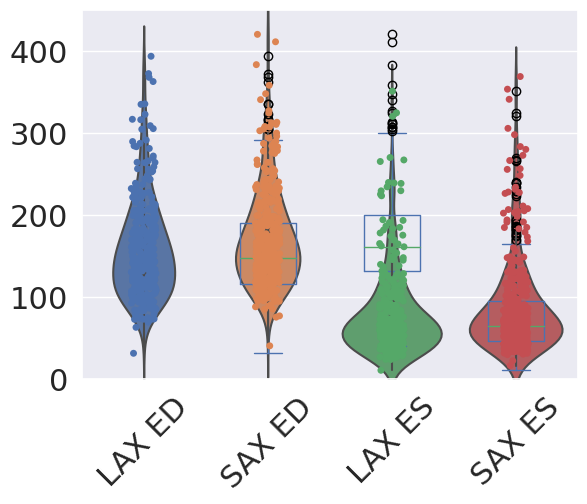

In [289]:
from src.visualization.Visualize import plot_pfd_per_phase_as_violin

volumes={
    'LAX ED':lax_ed,
    'LAX ES': lax_es,
    'LAX Delta': lax_delta,
    'SAX ED': sax_ed,
    'SAX ES':  sax_es,
    'SAX Delta':  sax_delta,
}
volumes_df = pd.DataFrame(volumes)

plot_pfd_per_phase_as_violin(volumes_df[['LAX ED', 'SAX ED', 'LAX ES', 'SAX ES']],y_limit=450)

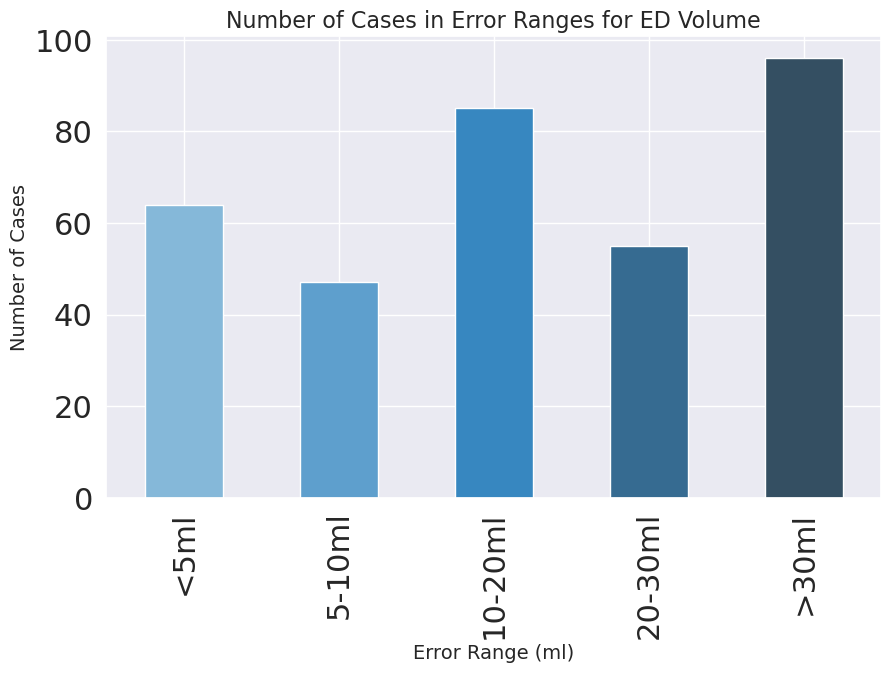

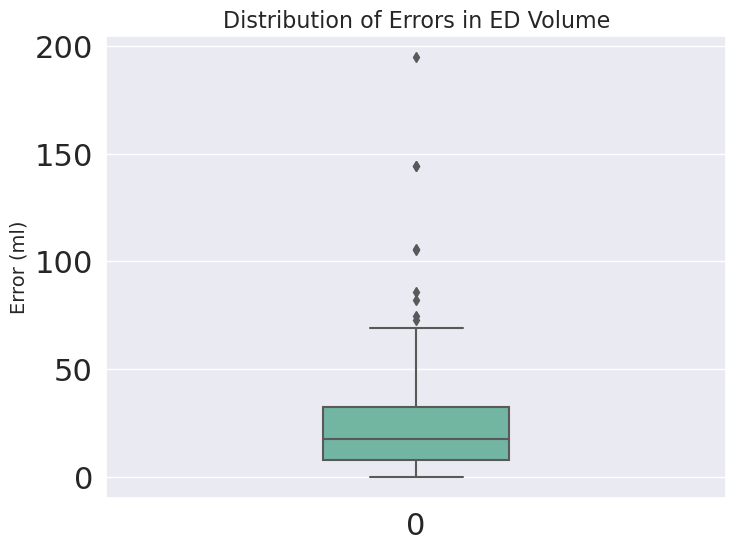

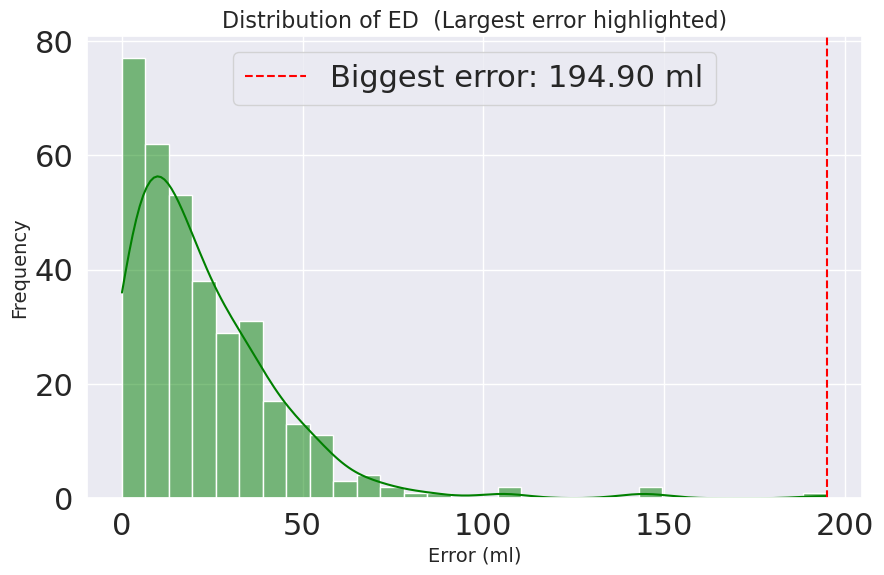

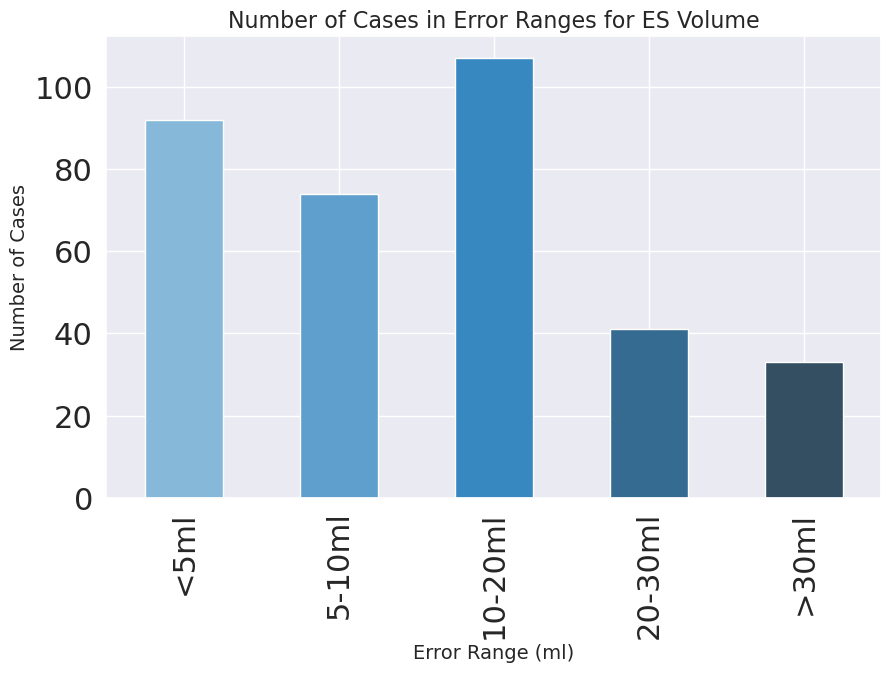

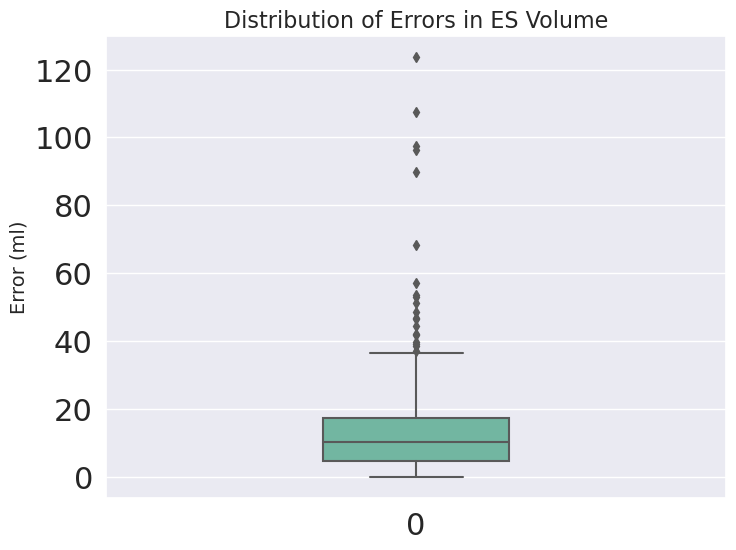

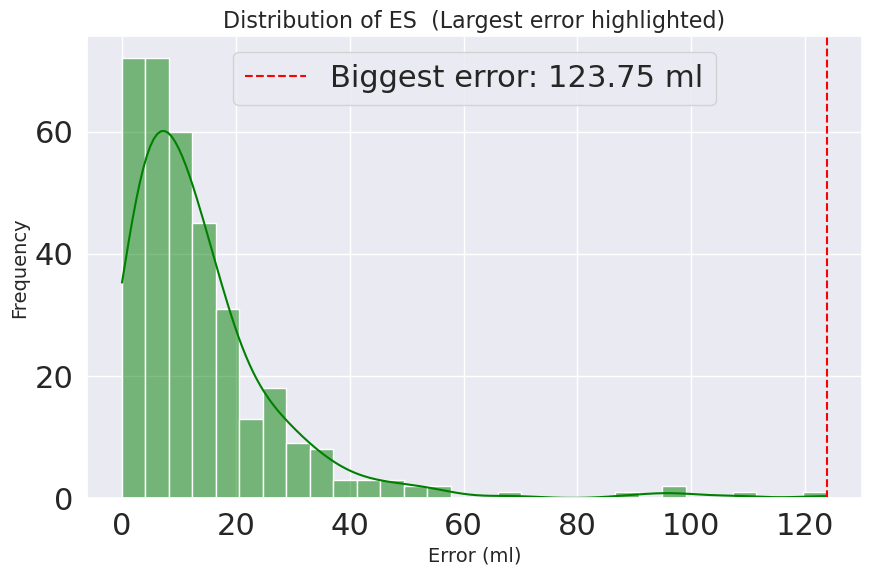

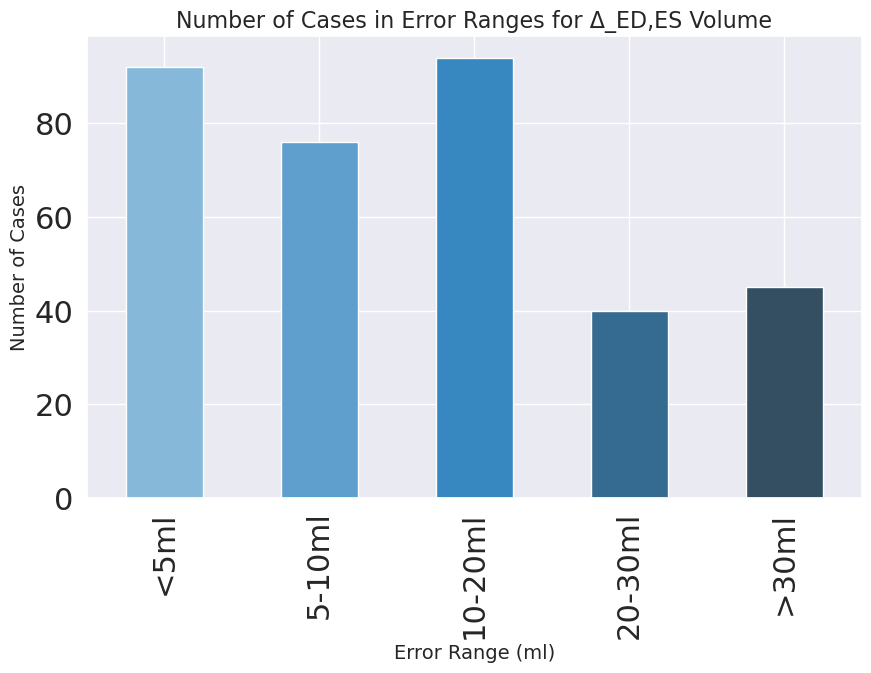

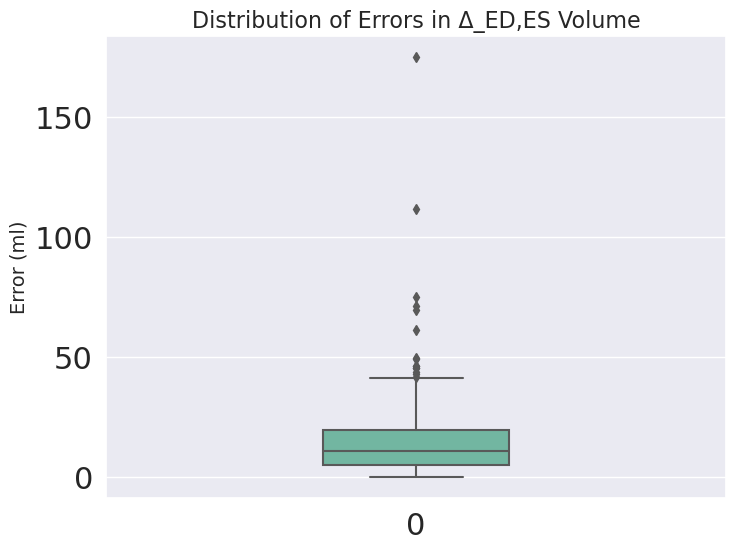

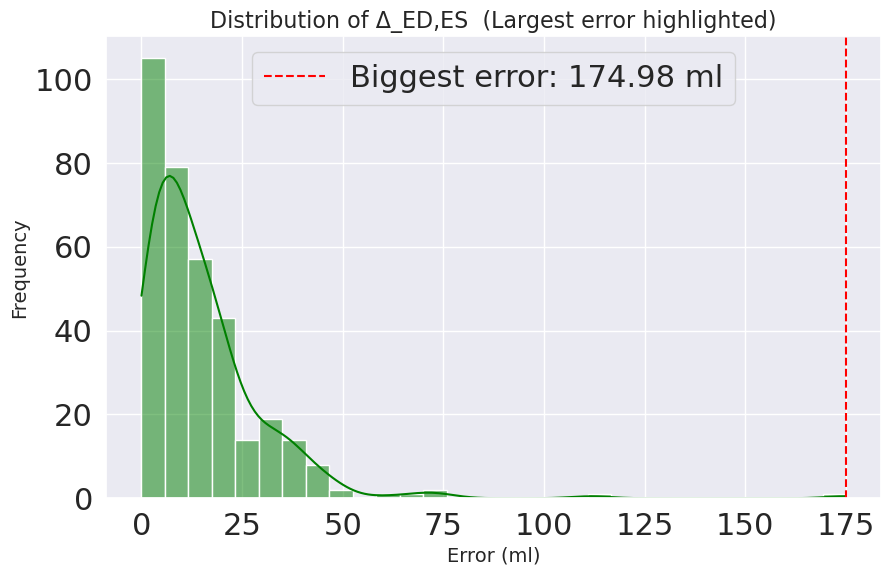

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def categorize_errors(errors):
    # Define bins for categorization
    bins = [0, 5, 10, 20, 30, np.inf]
    labels = ['<5ml', '5-10ml', '10-20ml', '20-30ml', '>30ml']
    return pd.cut(errors, bins=bins, labels=labels, right=False)

def visualize_error(approx_errors, name = "ES"): 
    categories = categorize_errors(approx_errors)
    counts = categories.value_counts() 
    max_error=max(approx_errors)
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("Blues_d", len(counts))
    counts.plot(kind='bar', figsize=(10, 6), color=palette)
    plt.title(f'Number of Cases in Error Ranges for {name} Volume', fontsize=16)
    plt.xlabel('Error Range (ml)', fontsize=14)
    plt.ylabel('Number of Cases', fontsize=14)
    plt.show()

    # Box plot to show distribution of errors and outliers
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=approx_errors, palette="Set2", width=0.3)
    plt.title(f'Distribution of Errors in {name} Volume', fontsize=16)
    plt.ylabel('Error (ml)', fontsize=14)
    plt.show()

    # Histogram to show the distribution of errors
    plt.figure(figsize=(10, 6))
    sns.histplot(approx_errors, bins=30, kde=True, color='green')
    plt.axvline(max_error, color='red', linestyle='--', label=f'Biggest error: {max_error:.2f} ml')
    plt.title(f'Distribution of {name}  (Largest error highlighted)', fontsize=16)
    plt.xlabel('Error (ml)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.show()
   

visualize_error(direct_error_ed, name="ED")
visualize_error(direct_error_es, name="ES")
visualize_error(direct_error_all, name="Δ_ED,ES")

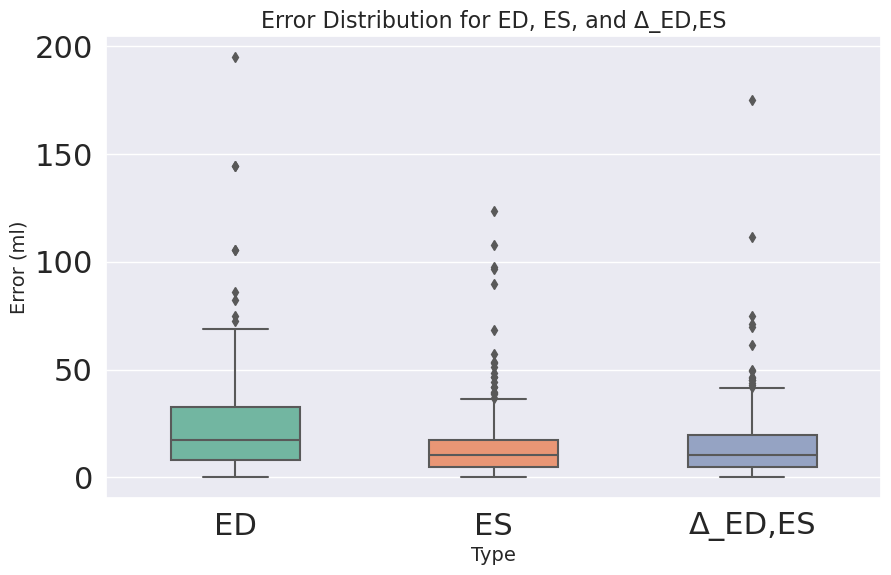

In [256]:
def box_plot_errors(error_ED, error_ES, error_diff):
    errors = np.concatenate([error_ED, error_ES, error_diff])
    labels = ['ED'] * len(error_ED) + ['ES'] * len(error_ES) + ['Δ_ED,ES'] * len(error_diff)

    # Create a DataFrame (optional, Seaborn works well with long-format data)
    import pandas as pd
    error_data = pd.DataFrame({'Error': errors, 'Type': labels})

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Type', y='Error', data=error_data, palette="Set2", width=0.5)
    plt.title('Error Distribution for ED, ES, and Δ_ED,ES', fontsize=16)
    plt.xlabel('Type', fontsize=14)
    plt.ylabel('Error (ml)', fontsize=14)
    plt.show()
    
box_plot_errors(direct_error_ed, direct_error_es, direct_error_all)

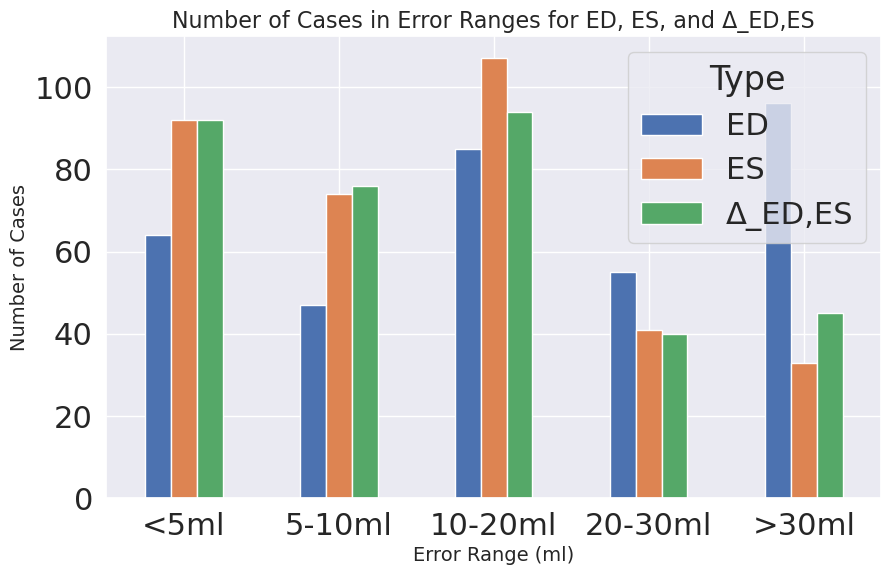

347


In [262]:
def bar_chart_errors(error_ED, error_ES, error_diff):
    # Categorize each set of errors into bins
    ed_categories = categorize_errors(error_ED)
    es_categories = categorize_errors(error_ES)
    diff_categories = categorize_errors(error_diff)

    # Count the number of occurrences in each category for ED, ES, and Difference
    ed_counts = ed_categories.value_counts()  # Removed sort=False
    es_counts = es_categories.value_counts()  # Removed sort=False
    diff_counts = diff_categories.value_counts()  # Removed sort=False

    # Combine the counts into a DataFrame for easier plotting
    error_counts = pd.DataFrame({
        'ED': ed_counts,
        'ES': es_counts,
        'Δ_ED,ES': diff_counts
    })

    # Create a grouped bar plot
    error_counts.plot(kind='bar', figsize=(10, 6))
    plt.title('Number of Cases in Error Ranges for ED, ES, and Δ_ED,ES', fontsize=16)
    plt.xlabel('Error Range (ml)', fontsize=14)
    plt.ylabel('Number of Cases', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title="Type")
    plt.show()
    print(sum(ed_counts))
    
bar_chart_errors(direct_error_ed, direct_error_es, direct_error_all)

# 4. Experiments with masks

In [21]:
# load a list of files with masks in step 3 before you continue
print(len(masked_niftis))

160


In [54]:
def get_ip_from_2dmask(nda, debug=False, rev=False):
    """
    Find the RVIP on a 2D mask with the following labels
    RV M(0), LVMYO (1) and LV (2) mask

    Parameters
    ----------
    nda : numpy ndarray with one hot encoded labels
    debug :

    Returns a tuple of two points anterior IP, inferior IP, each with (y,x)-coordinates
    -------

    """
    if debug: print('msk shape: {}'.format(nda.shape))
    # initialise some values
    first, second = None, None
    # find first and second insertion points
    rv_msk = (nda == 3).astype(np.uint8)
    comb_msk = ((nda == 1) | (nda == 2) | (nda == 3)).astype(np.uint8)
    
    print(type(rv_msk))
    print(type(comb_msk))
    
    rv_contours, hierarchy = cv2.findContours(rv_msk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    comb_contours, hierarchy = cv2.findContours(comb_msk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(rv_contours) > 0 and len(comb_contours) > 0:  # we just need to search for IP if there are two contours
        # some lambda helpers
        # transform and describe contour lists to pythonic list which makes "elem in" syntax possible
        clean_contour = lambda cont: list(map(lambda x: (x[0][0], x[0][1]), cont[0]))
        descr_cont = lambda cont: print(
            'len: {}, first elem: {}, type of one elem: {}'.format(len(cont), cont[0], type(cont[0])))

        # clean/describe both contours
        rv_clean = clean_contour(rv_contours)
        if debug: descr_cont(rv_clean)
        comb_clean = clean_contour(comb_contours)
        if debug: descr_cont(comb_clean)

        # initialise some values
        septum_visited = False
        border_visited = False
        memory_first = None
        for p in rv_clean:
            if debug: print('p {} in {}'.format(p, p in comb_clean))
            # we are at the border,
            # moving anti-clockwise,
            # we dont know if we are in the septum
            # no second IP found so far.

            if p in comb_clean:
                border_visited = True
                if septum_visited and not second:
                    # take the first point after the septum as second IP
                    # we are at the border
                    # we have been at the septum
                    # no second defined so far
                    second = p
                    if debug: print('second= {}'.format(second))

                # we are at the border
                if not first:
                    # if we haven't been at the septum, update/remember this point
                    # use the last visited point before visiting the septum as first IP
                    memory_first = p
                    if debug: print('memory= {}'.format(memory_first))
            else:
                septum_visited = True  # no contour points matched --> we are at the septum
                if border_visited and not first:
                    first = memory_first
        if second and not first:  # if our contour started at the first IP
            first = memory_first
        # assert first and second, 'missed one insertion point: first: {}, second: {}'.format(first, second)
        if debug: print('first IP: {}, second IP: {}'.format(first, second))
    if rev: first, second = (first[1], first[0]), (second[1], second[0])

    return first, second

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


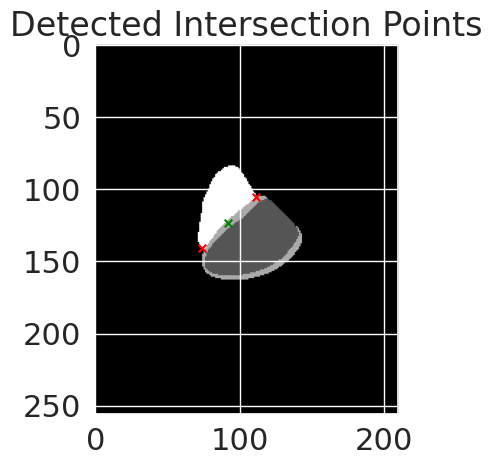

In [55]:
file = masked_niftis[27]
nifti = sitk.ReadImage(file)
mask = sitk.GetArrayFromImage(nifti)[0,0,...]
intersection_pts = find_intersection_points(mask)

print(type(mask))

intersection_pts = get_ip_from_2dmask(mask)
if intersection_pts[0] is not None and  intersection_pts[1] is not None:
    x_coord = np.array([ intersection_pts[0][0],  intersection_pts[1][0]]).mean(axis=0).astype(int)
    y_coord = np.array([ intersection_pts[0][1],  intersection_pts[1][1]]).mean(axis=0).astype(int)
    focus = np.array([x_coord, y_coord])
# Display the result
plt.imshow(mask, cmap="gray")
for pt in intersection_pts:
    plt.scatter(pt[0], pt[1], color="red", s=30, marker="x")  # Mark intersections
plt.scatter(focus[0], focus[1], color="green", s=30, marker="x")
plt.title("Detected Intersection Points")
plt.show()